# Validating an OH Megamaser Search Pipeline: Scenario 3 (randomized masers, sky model/foregrounds [with delay filter], and realistic RFI masking ~ 40%)

This notebook demonstrates a streamlined and validated simulation pipeline for searching for OH megamasers (OHMs) with a CHIME-like telescope. The primary goal is to verify that the core of the search algorithm—the matched filter—is performing exactly as expected under idealized conditions.

This notebook is for **Scenario 3**: a complicated simulation containing synthetic OHM signals, the GDSM sky model, and pure Gaussian noise. In addition there is Radio Frequency Interference (RFI) masking, and a delay filter. This allows us the most realistic test of the matched filter's ability to boost the signal-to-noise ratio (SNR) of real signals.

The key validation steps are:
1.  **3D Candidate Finding**: We use a 3D clustering algorithm (DBSCAN) on the full SNR data cube for robust candidate identification.
2.  **Enhanced Performance Metrics**: In addition to completeness and purity, we calculate the *predicted* number of true and false positives based on the injected signal properties.
3.  **SNR Boost Validation**: We will predict the theoretical SNR boost for each injected maser and compare it to the actual measured boost from the pipeline via a histogram. This is a critical diagnostic to confirm the matched filter is optimal.
4.  **Diagnostic Plots**: We will use a suite of plots, including histograms of the data and SNR cubes, to visually confirm that the pipeline is behaving as expected.

In [1]:
# Part 1: Setup and Module Imports
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from scipy.stats import norm
import scipy.stats as stats
import matplotlib
import cmocean

# Import our custom pipeline modules
import ohm_template_generator as otg
import ohm_search_simulator as oss
import ohm_candidate_finder as ocf

print("All modules imported successfully.")

All modules imported successfully.


## Part 2: Simulation Configuration

Here, we define the parameters for our simulation. We'll create a 64x64 pixel sky image with 1024 frequency channels. We are injecting 200 synthetic OHM signals into a background of pure Gaussian noise. This setup is designed to be the simplest, cleanest test of our matched filter.

In [2]:
# Simulation Parameters for Scenario 3
N_PIXELS = 64 * 64
GRID_SHAPE = (64, 64)
FREQS_MHZ = np.linspace(400, 800, 1024)
VEL_AXIS = np.linspace(-1200, 1200, 4096) # High-res velocity axis for template generation
N_INJECTIONS = 200
NOISE_SIGMA = 1.0 # Standard deviation of the Gaussian noise

# Search Algorithm Parameters
SNR_THRESHOLD = 5.0 # 7-sigma detection threshold
DBSCAN_EPS = 3      # DBSCAN clustering distance (in pixels/channels)
DBSCAN_MIN_SAMPLES = 5 # DBSCAN minimum cluster size


### Amplitude Analysis

The noise is set to a standard deviation of 1.0 (`NOISE_SIGMA = 1.0`). We can think of this as our "base unit" of `1σ = 0.5 mJy`.

The critical line for the injected signal strength is in Part 3:
`amp_inject = np.abs(np.random.normal(loc=5, scale=2)) * NOISE_SIGMA`

This means the amplitudes of our injected masers are drawn from a normal distribution centered at **5 times the noise sigma**, with a standard deviation of 2 sigma.

**Let's compare this to your physical expectations:**

* **Your physical scenario:**
    * Noise floor: `0.5 mJy`
    * Brightest masers: `5 mJy`
    * **Signal-to-Noise Ratio (SNR):** `5 mJy / 0.5 mJy = 10σ`


* **Our simulation:**
    * Noise sigma: `1.0` (which we equate to `0.5 mJy`)
    * Typical maser amplitude: `5.0` (which we equate to `2.5 mJy`)
    * **Signal-to-Noise Ratio (SNR):** `5.0 / 1.0 = 5σ`

### Is it physically sensible?

**Yes, absolutely.** Our simulation is not only physically sensible, it's actually a very good test case because it's slightly more **pessimistic** than your stated expectations.

We are testing the pipeline against a population of masers that are, on average, around **5σ**, while you expect the brightest ones to be around **10σ**. If our pipeline works well at finding these 5σ signals, it will have no problem finding the brighter 10σ ones.

Furthermore, your point about gravitational lensing is key. A lensed maser could be significantly brighter, perhaps 20-30 mJy, leading to a 40-60σ detection! Our simulation proves that the core logic works on the fainter, more challenging signals, giving us high confidence that it will work on the extremely bright ones too.

## Part 3: Generating Simulated Sky Data

We now generate the simulated 3D data cube. This involves two main steps:
1.  **Signal Injection**: We create `N_INJECTIONS` synthetic OHM signals with random redshifts and amplitudes. The noiseless profiles of these signals are stored in the `ground_truth` dictionary. This dictionary is our "answer key" for the validation process.
2.  **Noise Generation**: We create a data cube of the specified dimensions filled with Gaussian noise with a standard deviation of `NOISE_SIGMA`.

The injected signals are then added to the noise cube to produce our final simulated data.

In [3]:
# 1. Generate the single, high-resolution "master" template in velocity space ONCE.
print("--- Generating Optimal Intrinsic Template (Once) ---")
intrinsic_template_v = otg.create_intrinsic_template(
    N_population=5000, 
    vel_axis_kms=VEL_AXIS, 
    verbose=False
)

--- Generating Optimal Intrinsic Template (Once) ---


In [4]:
# --- Scenario 3: Generating Simulated Sky Data with RFI ---
print("--- Generating Simulated Sky Data for Scenario 2 (with RFI) ---")

# 1. Generate the data cube using the dedicated simulation function
#    We will use a blank sky, uniform noise, and no foregrounds for this scenario.
data_cube, ground_truth, sky_weights = oss.generate_sky_image_cube(
    num_pixels=N_PIXELS,
    freqs=FREQS_MHZ,
    noise_sigma_base=NOISE_SIGMA,
    num_injections=N_INJECTIONS,
    sky_model='gdsm',          # Use a blank sky for now
    noise_model='uniform',      # Use uniform noise across all pixels
)

print(f"\nSuccessfully generated data cube with {len(ground_truth['injections'])} injected signals.")

# 2. Generate and Apply a Realistic RFI Mask
#    This step happens *after* the cube is generated, simulating how real data is flagged.
rfi_weights = oss.generate_realistic_rfi_mask(FREQS_MHZ)
# A boolean mask is often easier to work with than weights
rfi_mask_boolean = rfi_weights.astype(bool) 

# Apply the mask to the data cube by setting flagged channels to zero.
data_cube[:, ~rfi_mask_boolean] = 0

percent_flagged = 100 * (1 - np.mean(rfi_weights))
print(f"\nApplied RFI mask. {percent_flagged:.1f}% of frequency channels have been flagged.")

--- Generating Simulated Sky Data for Scenario 2 (with RFI) ---
Generating simulation cube with 4096 pixels...
  - Generating 'gdsm' sky model.
  - Initializing Global Sky Model...


Generating GDSM slices:   0%|          | 0/1024 [00:00<?, ?it/s]

  - Generating 'uniform' noise weights.


Injecting Signals:   0%|          | 0/200 [00:00<?, ?it/s]


  - Adding instrumental noise...


Adding Noise:   0%|          | 0/4096 [00:00<?, ?it/s]


Successfully generated data cube with 200 injected signals.
  - Generating realistic stationary RFI mask...

Applied RFI mask. 39.3% of frequency channels have been flagged.


--- Displaying Sample Spectra with RFI Masking ---


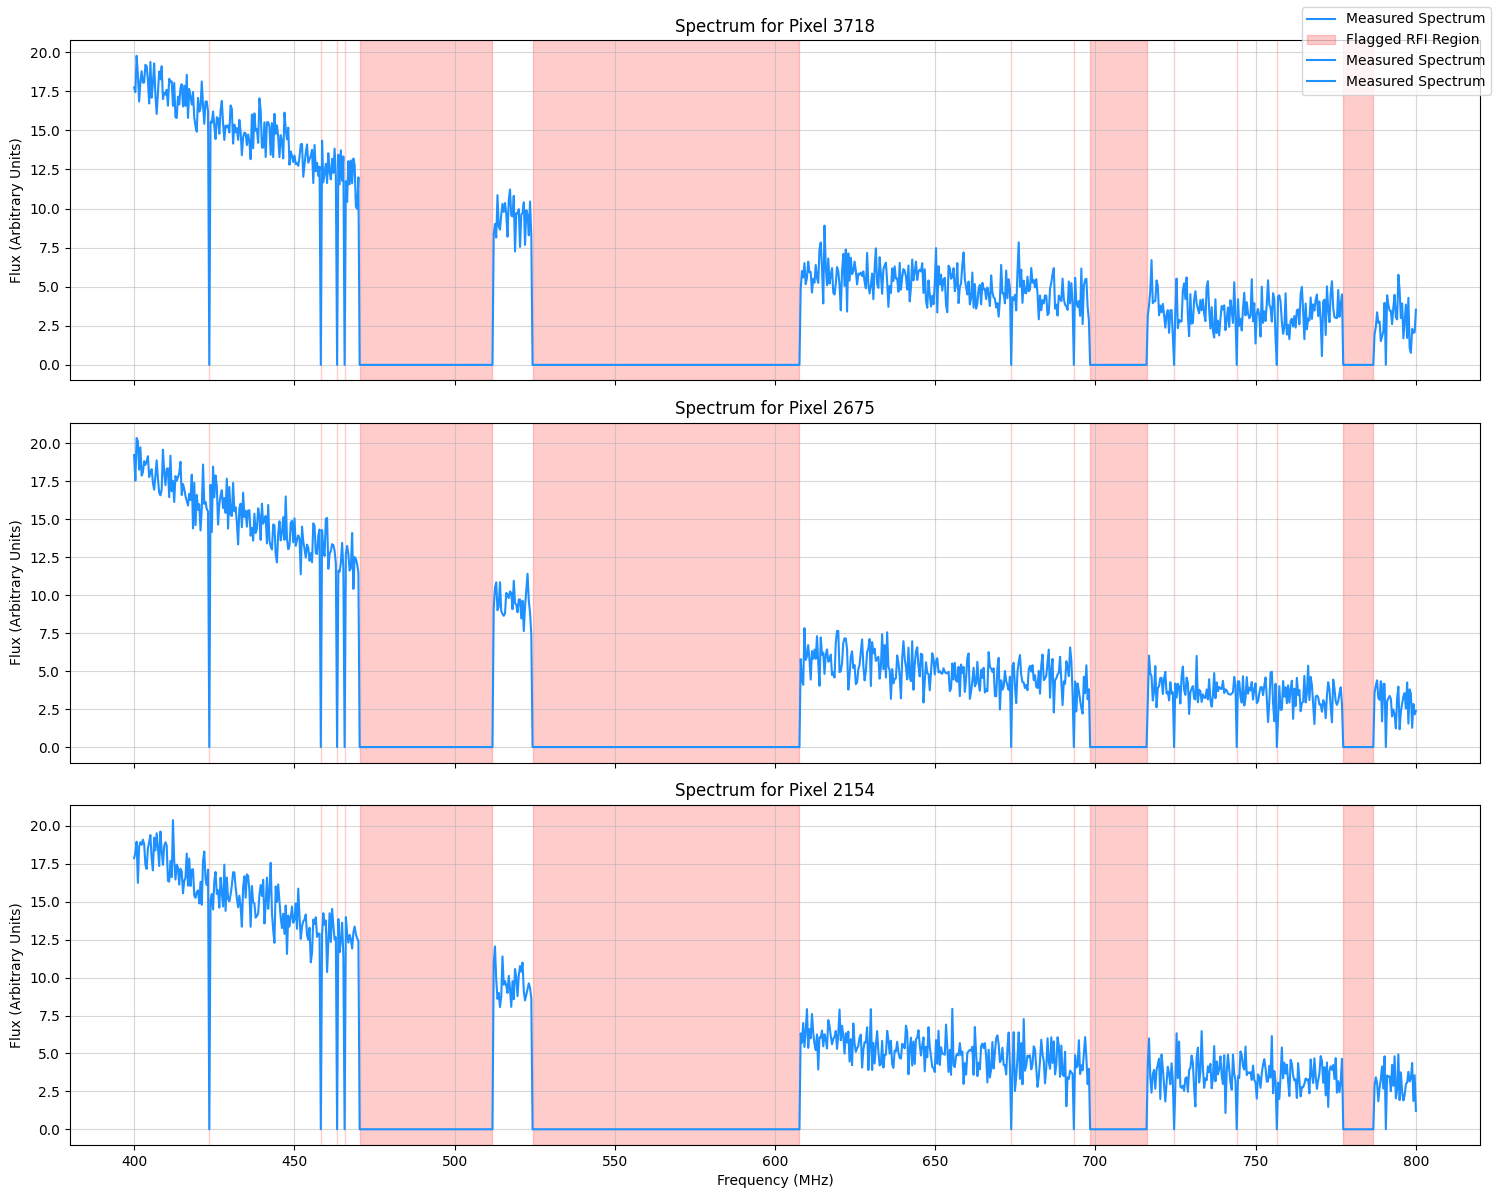

In [5]:
print("--- Displaying Sample Spectra with RFI Masking ---")

# Select a few random pixels to inspect
num_to_plot = 3
pixel_indices_to_plot = np.random.choice(N_PIXELS, num_to_plot, replace=False)

# Create the plot
fig, axes = plt.subplots(num_to_plot, 1, figsize=(15, 4 * num_to_plot), sharex=True)
if num_to_plot == 1:
    axes = [axes] # Ensure axes is always iterable

for i, pixel_idx in enumerate(pixel_indices_to_plot):
    ax = axes[i]
    
    # Plot the spectrum from the data cube
    ax.plot(FREQS_MHZ, data_cube[pixel_idx, :], color='dodgerblue', label='Measured Spectrum')
    
    # Highlight the flagged RFI regions in red
    # `rfi_mask_boolean` is True for GOOD channels, so we plot where it's False
    flagged_indices = np.where(~rfi_mask_boolean)[0]
    
    # To avoid plotting thousands of individual lines, we can find contiguous blocks
    for start in np.where(np.diff(flagged_indices) > 1)[0]:
        end_idx = flagged_indices[start]
        start_idx = flagged_indices[np.where(np.diff(flagged_indices) > 1)[0][np.where(np.where(np.diff(flagged_indices) > 1)[0] == start)[0][0]-1]+1] if start !=0 else flagged_indices[0]
        ax.axvspan(FREQS_MHZ[start_idx], FREQS_MHZ[end_idx], color='red', alpha=0.2, label='Flagged RFI Region' if i == 0 and start == np.where(np.diff(flagged_indices) > 1)[0][0] else "")


    ax.set_title(f'Spectrum for Pixel {pixel_idx}')
    ax.set_ylabel('Flux (Arbitrary Units)')
    ax.grid(True, alpha=0.5)

ax.set_xlabel('Frequency (MHz)')
fig.legend(loc='upper right')
plt.tight_layout()
plt.show()

### Scenario 3: Foreground Subtraction with a Delay Filter

The most significant contaminant in our data, even more so than instrumental noise, is the sky itself. Our galaxy and distant radio sources produce incredibly bright foreground emission that is smooth in frequency. This smooth-spectrum emission can be thousands of times brighter than the faint, narrow-band OHM signals we are searching for.

To detect our signals, we must first remove this overwhelming foreground. We can achieve this by transforming our data from the frequency domain into the **delay domain**.

#### What is Delay Space? ⏳

A Fourier transform of a frequency spectrum produces its corresponding "delay spectrum." In this delay space, a signal's properties are mapped differently:

  * **Spectrally Smooth Signals**: Bright, smooth-spectrum sources (like our foregrounds) have very little variation across frequency. In delay space, this means their power is highly concentrated at the origin, at **low delays** (near 0 ns).
  * **Spectrally Complex Signals**: Faint, narrow-band signals (like our OHM masers) have sharp, complex features in the frequency domain. In delay space, this complexity spreads their power far from the origin, out to **high delays**.

#### The Delay Filter

This separation allows us to apply a powerful filter. We perform a Fourier transform on the data, set a "notch" at the center to remove everything at low delay (the foregrounds), and then transform the data back to the frequency domain. The result is a "delay-filtered" spectrum where the bright, smooth foregrounds have been effectively subtracted, allowing the faint, high-delay maser signals to become visible. We will use a **250 ns** delay cut, which is a strong filter designed to aggressively remove foregrounds.

-----

### Applying the Delay Filter


In [14]:
print("--- Applying Delay Filter to Scenario 3 Data Cube ---")
print("This will remove the bright, smooth-spectrum foregrounds.")

# Define the strength of our delay filter cut
DELAY_CUT_NS = 250.0

# Create a new data cube to store the filtered results
delay_filtered_cube = np.zeros_like(data_cube)

# The 'rfi_weights' array (1 for good, 0 for bad) is crucial for the filter
# to know which channels to ignore during the Fourier transform.
if 'rfi_weights' not in locals():
    # If the RFI weights aren't in memory, regenerate them.
    print("RFI weights not found, regenerating...")
    rfi_weights = oss.generate_realistic_rfi_mask(FREQS_MHZ)

# # Iterate through each pixel's spectrum and apply the filter
# for i in tqdm(range(N_PIXELS), desc=f"Applying {DELAY_CUT_NS}ns Delay Filter"):
#     spectrum = data_cube[i, :]
    
#     # Apply the delay filter using the function from the simulator module
#     filtered_spectrum = oss.apply_physical_delay_filter(
#         spectrum=spectrum,
#         weights=rfi_weights,
#         freqs_mhz=FREQS_MHZ,
#         delay_cut_ns=DELAY_CUT_NS
#     )
#     delay_filtered_cube[i, :] = filtered_spectrum

# --- 1. Apply the Windowed Delay Filter to the Data Cube ---
print("--- Applying Windowed Delay Filter to Data Cube ---")
DELAY_CUT_NS = 250.0
delay_filtered_cube = np.zeros_like(data_cube)
for i in tqdm(range(N_PIXELS), desc=f"Applying {DELAY_CUT_NS}ns Windowed Filter"):
    # Use the correct function from the simulator module
    delay_filtered_cube[i, :] = oss.apply_windowed_delay_filter(
        spectrum=data_cube[i, :],
        weights=rfi_weights,
        freqs_mhz=FREQS_MHZ,
        delay_cut_ns=DELAY_CUT_NS
    )

print("\nDelay filtering complete.")
print("The 'delay_filtered_cube' is now ready for the matched filter search.")

# As a sanity check, let's compare the standard deviation before and after.
# The filtered cube should have a much lower std dev because the bright foregrounds are gone.
std_before = np.std(data_cube[data_cube != 0])
std_after = np.std(delay_filtered_cube[delay_filtered_cube != 0])

print(f"\nStandard deviation before filtering: {std_before:.2f}")
print(f"Standard deviation after filtering:  {std_after:.2f}")

--- Applying Delay Filter to Scenario 3 Data Cube ---
This will remove the bright, smooth-spectrum foregrounds.


Applying 250.0ns Delay Filter:   0%|          | 0/4096 [00:00<?, ?it/s]


Delay filtering complete.
The 'delay_filtered_cube' is now ready for the matched filter search.

Standard deviation before filtering: 5.11
Standard deviation after filtering:  1.21


--- Displaying Sample Spectra with RFI Masking ---


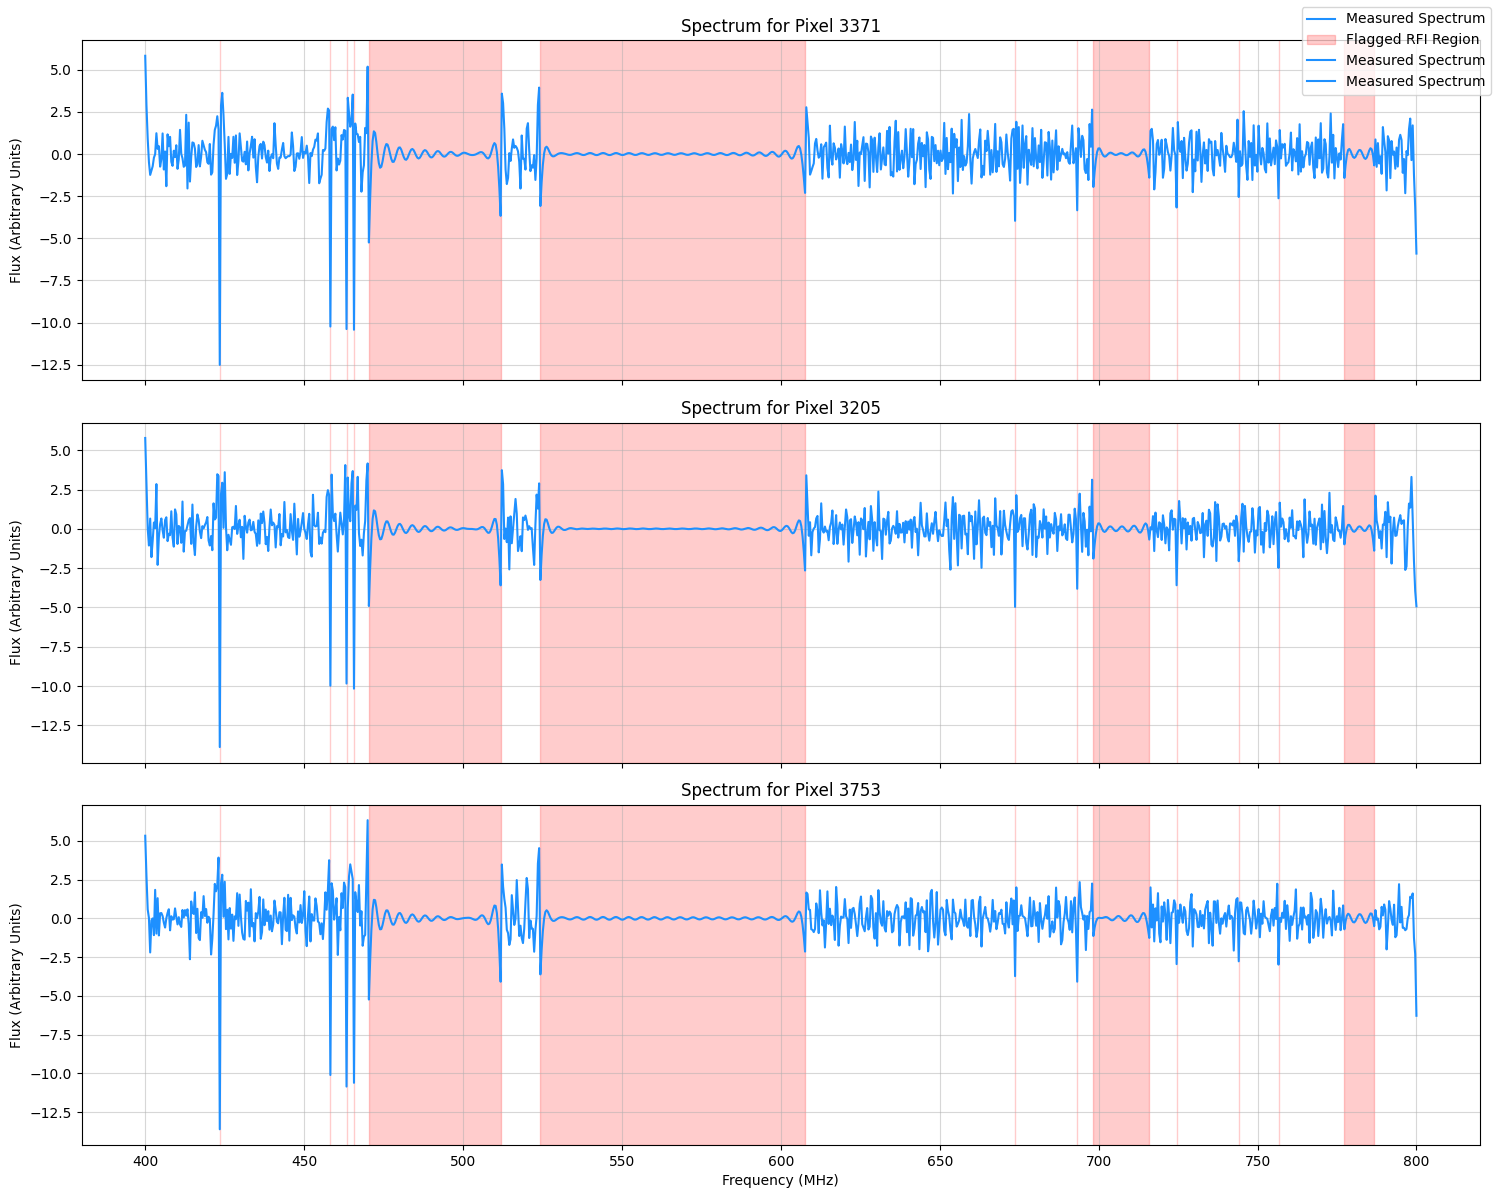

In [15]:
print("--- Displaying Sample Spectra with RFI Masking ---")

# Select a few random pixels to inspect
num_to_plot = 3
pixel_indices_to_plot = np.random.choice(N_PIXELS, num_to_plot, replace=False)

# Create the plot
fig, axes = plt.subplots(num_to_plot, 1, figsize=(15, 4 * num_to_plot), sharex=True)
if num_to_plot == 1:
    axes = [axes] # Ensure axes is always iterable

for i, pixel_idx in enumerate(pixel_indices_to_plot):
    ax = axes[i]
    
    # Plot the spectrum from the data cube
    ax.plot(FREQS_MHZ, delay_filtered_cube[pixel_idx, :], color='dodgerblue', label='Measured Spectrum')
    
    # Highlight the flagged RFI regions in red
    # `rfi_mask_boolean` is True for GOOD channels, so we plot where it's False
    flagged_indices = np.where(~rfi_mask_boolean)[0]
    
    # To avoid plotting thousands of individual lines, we can find contiguous blocks
    for start in np.where(np.diff(flagged_indices) > 1)[0]:
        end_idx = flagged_indices[start]
        start_idx = flagged_indices[np.where(np.diff(flagged_indices) > 1)[0][np.where(np.where(np.diff(flagged_indices) > 1)[0] == start)[0][0]-1]+1] if start !=0 else flagged_indices[0]
        ax.axvspan(FREQS_MHZ[start_idx], FREQS_MHZ[end_idx], color='red', alpha=0.2, label='Flagged RFI Region' if i == 0 and start == np.where(np.diff(flagged_indices) > 1)[0][0] else "")


    ax.set_title(f'Spectrum for Pixel {pixel_idx}')
    ax.set_ylabel('Flux (Arbitrary Units)')
    ax.grid(True, alpha=0.5)

ax.set_xlabel('Frequency (MHz)')
fig.legend(loc='upper right')
plt.tight_layout()
plt.show()

-----

### Interactive Viewer: Before and After Delay Filtering

To build intuition for how our foreground filter works, this interactive plot allows you to compare spectra from the same pixel side-by-side.

  * **The Left Panel** shows the raw spectrum from the GDSM simulation, including the bright, smooth foreground component.
  * **The Right Panel** shows the same spectrum *after* the **250 ns** delay filter has been applied.

Notice how the large-scale, smooth structure is removed, leaving behind what is essentially flat, Gaussian-like noise. The standard deviation ($\\sigma$) of the flux, printed in the corner of each plot, provides a quantitative measure of this effect. The goal of the filter is to dramatically reduce the standard deviation of the data before we search for faint signals.

Use the slider to explore different pixels in the simulated sky.

-----


In [16]:
from ipywidgets import interact, IntSlider
import warnings

# Suppress minor warnings from matplotlib to keep the output clean
warnings.filterwarnings("ignore", category=UserWarning)

def plot_spectral_comparison(pixel_index):
    """
    An interactive plotting function to compare a spectrum before and
    after delay filtering for a given pixel.
    """
    # Create a figure with two subplots side-by-side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6), sharey=True)
    fig.suptitle(f'Spectral Comparison for Pixel {pixel_index}', fontsize=16)

    # --- 1. Before Filtering ---
    spec_before = data_cube[pixel_index, :]
    std_before = np.std(spec_before[spec_before != 0]) # Exclude RFI-masked zeros
    ax1.plot(FREQS_MHZ, spec_before, color='firebrick', label='Before Filter')
    ax1.set_title('Before Filtering (Raw GDSM + Noise)')
    ax1.set_xlabel('Frequency (MHz)')
    ax1.set_ylabel('Flux (Arbitrary Units)')
    ax1.grid(True, alpha=0.5)
    # Display the standard deviation in the top-left corner
    ax1.text(0.02, 0.95, f'σ = {std_before:.2f}', transform=ax1.transAxes, 
             ha='left', va='top', bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.8))

    # --- 2. After Filtering ---
    spec_after = delay_filtered_cube[pixel_index, :]
    std_after = np.std(spec_after[spec_after != 0]) # Exclude RFI-masked zeros
    ax2.plot(FREQS_MHZ, spec_after, color='dodgerblue', label='After Filter')
    ax2.set_title('After Filtering (Foregrounds Removed)')
    ax2.set_xlabel('Frequency (MHz)')
    ax2.grid(True, alpha=0.5)
    # Display the standard deviation in the top-left corner
    ax2.text(0.02, 0.95, f'σ = {std_after:.2f}', transform=ax2.transAxes, 
             ha='left', va='top', bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.8))

    # Overlay the RFI mask on both plots for context
    if 'rfi_mask_boolean' in globals():
        flagged_indices = np.where(~rfi_mask_boolean)[0]
        for start in np.where(np.diff(flagged_indices) > 1)[0]:
            end_idx = flagged_indices[start]
            start_idx = flagged_indices[np.where(np.diff(flagged_indices) > 1)[0][np.where(np.where(np.diff(flagged_indices) > 1)[0] == start)[0][0]-1]+1] if start !=0 else flagged_indices[0]
            ax1.axvspan(FREQS_MHZ[start_idx], FREQS_MHZ[end_idx], color='red', alpha=0.1)
            ax2.axvspan(FREQS_MHZ[start_idx], FREQS_MHZ[end_idx], color='red', alpha=0.1)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# --- Create the Interactive Slider ---
interact(
    plot_spectral_comparison,
    pixel_index=IntSlider(min=0, max=N_PIXELS - 1, step=1, value=0, description='Pixel Index:')
);

interactive(children=(IntSlider(value=0, description='Pixel Index:', max=4095), Output()), _dom_classes=('widg…

Of course. That's an excellent idea. Visualizing the data in the image domain is just as important as viewing the spectra. This will allow you to scroll through the frequency channels and see how the spatial structure of the sky changes, especially how the bright foregrounds are removed by the delay filter.

Here are the markdown and Python cells to create this new interactive image viewer.

### Interactive Viewer: Image Slices vs. Frequency

This interactive viewer provides a different perspective on our data cube. Instead of looking at the spectrum for one pixel, we are now looking at the entire **2D sky image** at a **single frequency channel**.

  * **The Left Panel** shows the raw sky image at a specific frequency, including the GDSM foregrounds.
  * **The Right Panel** shows the same sky image *after* the delay filter has been applied.

Use the slider to scroll through the different frequency channels of the telescope. Notice how in the "Before" panel, the image is dominated by large-scale power from the foregrounds, while the "After" panel shows what is effectively a map of the instrumental noise. This viewer also tells you if the channel you are currently viewing is flagged for RFI.

-----

In [171]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
import cmocean
import warnings

# Suppress minor warnings from matplotlib to keep the output clean
warnings.filterwarnings("ignore", category=UserWarning)

def plot_image_comparison(frequency_index):
    """
    An interactive plotting function to compare a 2D sky image before and
    after delay filtering for a given frequency channel.
    """
    # Create a figure with two subplots side-by-side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
    
    # Determine the frequency and RFI status for the title
    freq_mhz = FREQS_MHZ[frequency_index]
    is_flagged = not rfi_mask_boolean[frequency_index]
    rfi_status_str = "FLAGGED FOR RFI" if is_flagged else "Clean"
    
    fig.suptitle(f'Sky Image at {freq_mhz:.2f} MHz (Channel {frequency_index}) | Status: {rfi_status_str}', 
                 fontsize=16, color='red' if is_flagged else 'black')

    # --- 1. Before Filtering ---
    # Get the image slice for this frequency and reshape it to our 2D grid
    img_before = data_cube[:, frequency_index].reshape(GRID_SHAPE)
    im1 = ax1.imshow(img_before, cmap=cmocean.cm.thermal, origin='lower', aspect='auto')
    ax1.set_title('Before Filtering (Raw GDSM + Noise)')
    ax1.set_xlabel('Pixel X-coordinate')
    ax1.set_ylabel('Pixel Y-coordinate')
    fig.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04, label='Flux')

    # --- 2. After Filtering ---
    img_after = delay_filtered_cube[:, frequency_index].reshape(GRID_SHAPE)
    # Use the same color scale for a fair comparison
    im2 = ax2.imshow(img_after, cmap=cmocean.cm.thermal, origin='lower', aspect='auto')#, 
                     #vmin=np.min(img_before), vmax=np.max(img_before))
    ax2.set_title('After Filtering (Foregrounds Removed)')
    ax2.set_xlabel('Pixel X-coordinate')
    ax2.set_ylabel('') # Hide y-axis label for clarity
    fig.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04, label='Flux')
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# --- Create the Interactive Slider ---
interact(
    plot_image_comparison,
    frequency_index=IntSlider(min=0, max=len(FREQS_MHZ) - 1, step=1, value=len(FREQS_MHZ)//2, description='Frequency Channel:')
);

interactive(children=(IntSlider(value=512, description='Frequency Channel:', max=1023), Output()), _dom_classe…

## Part 4: Matched Filtering and SNR Cube Generation

This is the core of the search pipeline. We apply a matched filter to our simulated data cube. The matched filter correlates the data with a set of pre-computed templates that model the expected signal shape at different redshifts.

The output is a 3D Signal-to-Noise (SNR) cube of the same dimensions as the data cube. Each voxel in this cube represents the SNR of the best-matching template at that specific sky position and frequency.

Of course! Here is a detailed markdown cell explaining the matched filter algorithm and the SNR boost calculation, complete with LaTeX equations.

***
### The Direct-Match, Multi-Template Matched Filter

Our pipeline employs a specialized matched filter designed for both efficiency and precision. Unlike a traditional approach that slides every template across the entire frequency spectrum (a full cross-correlation), our **direct-match** method tests each template only at its specific, corresponding frequency location. This provides a massive speed advantage while maintaining the core benefits of matched filtering.

The process can be broken down into four main steps:

---
#### Step 1: Building the Template Bank 🏦

The foundation of the search is a bank of realistic OHM signal templates. To avoid redundant calculations, we use a "generate once, transform many" approach:

1.  **Master Template Creation**: A single, high-resolution "master" template, $T_{\text{intrinsic}}(v)$, is generated in velocity space. This captures the intrinsic, double-peaked profile of a typical OHM signal.

2.  **Redshift Transformation**: This master template is then transformed to create a unique template for each redshift, $z$, in our search grid. This transformation maps the velocity profile to the observed frequency grid, $f_{\text{native}}$, accounting for the cosmological redshift:

    $T_z(f_{\text{native}}) = \text{transform}(T_{\text{intrinsic}}(v), z, f_{\text{native}})$

---
#### Step 2: The Direct-Match Search Algorithm 🎯

For each pixel in the sky, we take its measured frequency spectrum, $D(f)$, and test it against every template, $T_z$, in our bank. The core of the matched filter is the calculation of the Signal-to-Noise Ratio (SNR) for each template at its specific location. This is calculated as a normalized **inner product** (or dot product).

For a given template, $T_z$, which spans a specific range of frequency channels, the SNR is given by:

$\text{SNR}_z = \frac{\sum_{i} D_i \cdot T_{z,i}}{\sigma_{\text{noise}} \sqrt{\sum_{i} T_{z,i}^2}}$

where:
- $D_i$ is the data (flux) in the $i$-th frequency channel that the template overlaps.
- $T_{z,i}$ is the value of the template in that same channel.
- $\sigma_{\text{noise}}$ is the standard deviation (RMS) of the background noise.
- The term $\sqrt{\sum_{i} T_{z,i}^2}$ is the L2-norm (or "energy") of the template, which serves to properly normalize the result.

This calculation is performed for every template in the bank.

---
#### Step 3: Constructing the SNR Cube 🧊

As we calculate the SNR for each template, we build the final 3D Signal-to-Noise cube. Our algorithm "paints" the calculated SNR value across all the frequency channels that the corresponding template occupies.

Crucially, we only update a voxel's value if the new SNR is greater than the value already stored there. This ensures that for any given position in the cube, the final value represents the SNR of the **best-matching template** that overlaps that position.

---
#### Step 4: Predicting the SNR Boost ✨

A key validation step is to predict the theoretical SNR boost a signal *should* receive from the matched filter. This prediction tells us how much a signal with a known amplitude will be amplified relative to the noise.

For a noiseless injected signal, $S$, with a peak amplitude of $A_{\text{peak}}$, its theoretical SNR after filtering is:

$\text{Predicted SNR} = \frac{\sum_{i} S_i \cdot T_{S,i}}{\sigma_{\text{noise}} \sqrt{\sum_{i} T_{S,i}^2}}$

Here, $T_{S,i}$ is the **perfectly matched template** for that signal. Since the signal itself is just a scaled version of its perfect template ($S_i = A_{\text{peak}} \cdot T_{S,i}$), the equation simplifies beautifully:

$\text{Predicted SNR} = \frac{A_{\text{peak}} \sum_{i} T_{S,i}^2}{\sigma_{\text{noise}} \sqrt{\sum_{i} T_{S,i}^2}} = \frac{A_{\text{peak}}}{\sigma_{\text{noise}}} \sqrt{\sum_{i} T_{S,i}^2}$

This elegant result shows that the expected SNR is simply the signal's intrinsic SNR ($A_{\text{peak}}/\sigma_{\text{noise}}$) multiplied by the **energy of the normalized template**. This is the value we use to calculate the "Predicted True Positives" and to create the "Theoretical SNR" histogram.


#### 1. Peak SNR (Used for Detection)

This is the method our direct-match algorithm uses to **detect** signals and construct the initial SNR cube.

* **What it is**: The Peak SNR is the **single, maximum value** of the matched filter response. In our direct-match algorithm, the calculation `(data ⋅ template) / (σ * ||template||)` at a specific location is mathematically equivalent to finding the value at the peak of a full cross-correlation. The value we "paint" into the SNR cube represents this peak response.

* **Pros**:
    * **Simple Statistics**: The noise associated with the Peak SNR is well-described by a Gaussian distribution. This makes it straightforward to predict the false positive rate, as we have done in our analysis.
    * **Efficiency**: It is computationally simple and fast to calculate, making it ideal for the initial, brute-force search across the entire dataset.

* **Cons**:
    * **Sensitivity to Noise**: It can be sensitive to a single, unusually high or low noise value within the footprint of the signal. It doesn't use all the information across the signal's profile.

The equation we use for detection is a pure **Peak SNR**:

$\text{SNR}_{\text{peak}} = \frac{\sum_{i} D_i \cdot T_{z,i}}{\sigma_{\text{noise}} \cdot ||T_z||_2}$
*(where $||T_z||_2$ is the L2-norm)*



### Scenario 3 Matched Filter: Searching in Delay-Filtered Data

Now that the bright, smooth-spectrum foregrounds have been removed from our data cube, we can proceed with the matched filter search. However, because we have applied a linear filter (the delay filter) to our data, we must apply the **exact same filter to our templates** for the search to remain mathematically optimal.

A filter is only "matched" when the template has undergone the same processing as the signal it's trying to find. If we were to use our original, unfiltered templates to search the new, delay-filtered data, there would be a significant mismatch, and the filter's performance would be severely degraded.

The process is therefore:

1.  Generate a template for a given redshift.
2.  Apply the **250 ns** delay filter to this individual template.
3.  Calculate the normalization (energy) of this *new, filtered* template.
4.  Add the filtered template to the bank.

We then use this bank of filtered templates to search our `delay_filtered_cube`. The noise level ($\\sigma$) for the search is now calculated from this filtered cube, as it represents the true noise floor after foreground subtraction.

-----

### Matched Filter Search on Delay-Filtered Cube


--- Building Original (Unfiltered) Template Bank ---


Building Original Templates:   0%|          | 0/1050 [00:00<?, ?it/s]


Template bank created with 1037 original templates.

--- Estimating Noise Spectrum (Per-Channel) ---
Noise spectrum calculated with shape: (1024,)

--- Running Direct-Match Filter Search ---


Processing Pixels:   0%|          | 0/4096 [00:00<?, ?it/s]


SNR cube generation complete.


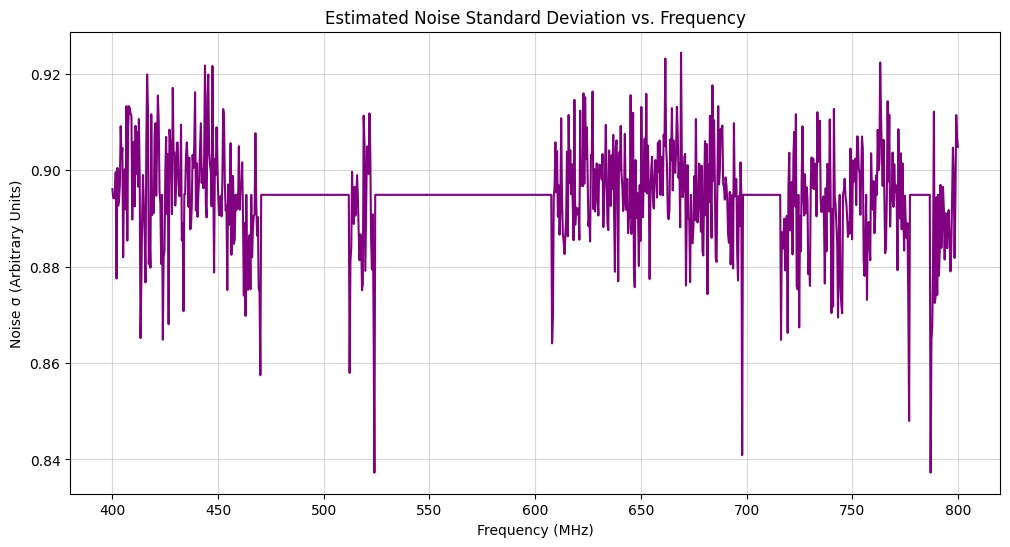

In [82]:
# --- Matched Filter Search (Original Templates, Per-Channel Noise) ---

# --- 1. Build the ORIGINAL, unfiltered template bank ---
print("--- Building Original (Unfiltered) Template Bank ---")
template_bank = []
# Ensure z_grid is defined from a previous cell, or define it here:
if 'z_grid' not in locals():
    z_grid = np.arange(1.05, 3.15, 0.002)

for z in tqdm(z_grid, desc="Building Original Templates"):
    template, start_idx, end_idx = otg.process_to_native_resolution(
        intrinsic_template_v=intrinsic_template_v,
        vel_axis_kms=VEL_AXIS,
        z=z,
        native_freq_grid=FREQS_MHZ
    )
    if template.size > 0 and start_idx is not None:
        # We store the profile, start, and end. The norm will be calculated in the loop.
        template_bank.append({'prof': template, 'start': start_idx, 'end': end_idx})

print(f"\nTemplate bank created with {len(template_bank)} original templates.")

# --- 2. Estimate the noise PER CHANNEL from the delay-filtered cube ---
print("\n--- Estimating Noise Spectrum (Per-Channel) ---")
# This uses the data cube that has had foregrounds removed
noise_spectrum = np.std(delay_filtered_cube, axis=0)
# Replace sigma in RFI-flagged channels with the median of clean channels
if 'rfi_mask_boolean' in locals():
    noise_spectrum[~rfi_mask_boolean] = np.median(noise_spectrum[rfi_mask_boolean])
print(f"Noise spectrum calculated with shape: {noise_spectrum.shape}")

# --- 3. Run the fast, direct-match search with per-channel noise normalization ---
print("\n--- Running Direct-Match Filter Search ---")
snr_cube_3d = np.zeros_like(delay_filtered_cube)

for i in tqdm(range(N_PIXELS), desc="Processing Pixels"):
    spectrum = delay_filtered_cube[i, :]
    pixel_snr_spectrum = np.zeros_like(spectrum)

    for temp_info in template_bank:
        start = temp_info['start']
        end = temp_info['end']
        template_profile = temp_info['prof']
        
        # Get the slice of the data and noise spectrum corresponding to this template
        data_segment = spectrum[start:end]
        noise_segment = noise_spectrum[start:end]
        
        # Calculate the effective normalization factor using the per-channel noise.
        # This is the L2-norm of the template divided by the noise at each channel.
        norm_effective = np.sqrt(np.sum((template_profile / noise_segment)**2))
        if norm_effective < 1e-6:
            continue
            
        # Correlate the data with the template, also weighted by the noise
        weighted_data = data_segment / noise_segment**2
        
        snr = np.sum(weighted_data * template_profile) / norm_effective
        
        # "Paint" the single SNR value across the template's footprint
        current_snr_segment = pixel_snr_spectrum[start:end]
        update_mask = snr > current_snr_segment
        pixel_snr_spectrum[start:end][update_mask] = snr
                
    snr_cube_3d[i, :] = pixel_snr_spectrum

print("\nSNR cube generation complete.")

# --- Sanity Check: Plot the Noise Spectrum ---
plt.figure(figsize=(12, 6))
plt.plot(FREQS_MHZ, noise_spectrum, color='purple')
plt.title('Estimated Noise Standard Deviation vs. Frequency')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Noise σ (Arbitrary Units)')
plt.grid(True, alpha=0.5)
plt.show()

## Part 5: 3D Candidate Finding with DBSCAN

With the SNR cube generated, we now identify significant signal candidates. Instead of simply taking the maximum SNR value in each pixel (a 2D approach), we use the **3D DBSCAN clustering algorithm**. This method treats the SNR cube as a 3D space and groups together neighboring voxels that are all above a certain SNR threshold.

This approach is more robust because:
* It is less susceptible to single-pixel noise spikes.
* It can distinguish between multiple sources at the same sky position but at different frequencies (redshifts).
* It provides a more accurate estimate of a candidate's centroid and extent in all three dimensions (sky position and frequency).

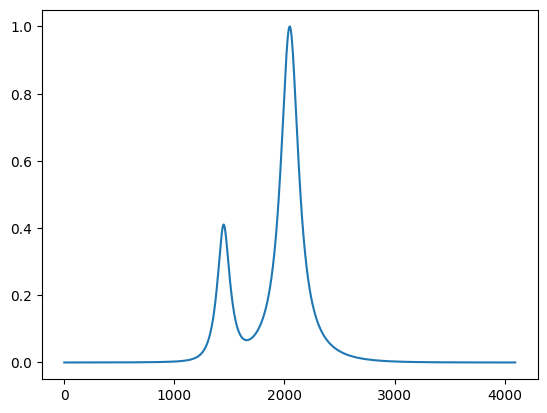

In [7]:
plt.plot(intrinsic_template_v);

In [8]:
template, start_idx, end_idx = otg.process_to_native_resolution(
        intrinsic_template_v=intrinsic_template_v,
        vel_axis_kms=VEL_AXIS,
        z=1.2,
        native_freq_grid=FREQS_MHZ
    )

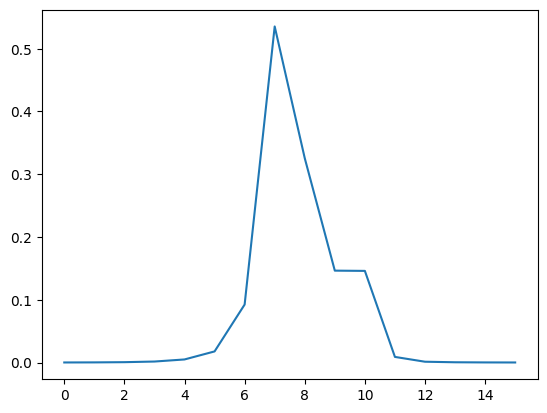

In [9]:
plt.plot(template);

In [10]:
snr_cube_3d.max()

np.float64(8.364052840644057)

***
### Finding Candidates with DBSCAN: From Voxel-Space to Physical Objects

After the matched filter has produced a 3D Signal-to-Noise Ratio (SNR) cube, the next critical step is to identify physically meaningful signal candidates within it. Simply picking out the highest SNR voxels is not robust; it's susceptible to single-channel noise spikes and doesn't group related parts of a signal together.

To solve this, we use **DBSCAN** (Density-Based Spatial Clustering of Applications with Noise), a powerful clustering algorithm that groups together closely packed points in space. By treating our 3D SNR cube as a spatial volume, DBSCAN allows us to identify contiguous regions of high SNR, effectively turning a cloud of voxels into a list of distinct candidate objects. 🔎

The process can be broken down into three main steps:

---
#### Step 1: Thresholding the SNR Cube

First, we apply our detection threshold ($\sigma_{\text{thresh}}$, e.g., 7.0) to the SNR cube. Any voxel with an SNR below this value is discarded. This leaves us with a sparse 3D map containing only the most significant SNR peaks, which become the input for the clustering algorithm.

---
#### Step 2: Running the DBSCAN Algorithm

DBSCAN works by defining a "cluster" based on two key parameters:

* **`eps` ($\epsilon$)**: The maximum distance (in our case, measured in pixels/channels) between two points for them to be considered neighbors.
* **`min_samples`**: The minimum number of points required to form a dense core region.

The algorithm iterates through the high-SNR voxels and classifies them:

1.  **Core Points**: A voxel is a **core point** if it has at least `min_samples` neighbors (including itself) within a radius of $\epsilon$. These are the hearts of our candidate clusters.
2.  **Border Points**: A voxel is a **border point** if it is within $\epsilon$ of a core point but does not have enough neighbors to be a core point itself. These are the edges of our candidates.
3.  **Noise Points**: Any voxel that is neither a core nor a border point is classified as **noise** and discarded.

DBSCAN connects core points that are neighbors, and then attaches their border points to form the final candidate clusters.

---
#### Step 3: Vetting Candidates and Rejecting RFI

This is where the power of DBSCAN as a "vetting" tool becomes clear. The algorithm's density-based nature provides an inherent defense against common types of noise and interference that a simple peak-finding algorithm would fail to reject:

* **Isolated Noise Spikes**: A random, single-channel noise fluctuation that happens to cross our SNR threshold will likely be isolated. Since it won't have `min_samples` neighbors, DBSCAN will correctly classify it as a **noise point** and discard it.

* **Broadband RFI**: Radio Frequency Interference (RFI) often appears as a signal that is strong across a very wide range of frequencies but is narrow in the spatial dimensions (i.e., it affects all pixels at a specific frequency). Let's say we have an RFI signal that is 1 pixel wide but 500 channels long. While it may have many high-SNR voxels, they are not clustered in a physically realistic, compact shape. By setting `eps` to a small, reasonable value (e.g., 3), DBSCAN would fail to find a dense **3D core** and would likely break this long, thin structure into many small, insignificant clusters that get discarded.

* **Instrumental Artifacts**: Other non-physical signals, like detector artifacts that might appear as lines or other strange shapes in the data cube, are also unlikely to form the kind of compact, 3D-ellipsoidal clusters that a real astrophysical signal would. DBSCAN's requirement for a dense core region makes it robust against such contaminants.

In essence, DBSCAN acts as a **morphological filter**, implicitly selecting for candidates that have the compact, 3D structure we expect from a real OH megamaser and rejecting those that are too sparse, too thin, or too oddly shaped to be astrophysical. This provides a critical layer of automated vetting before any human analysis is required.

Here is a markdown cell that explains the robust matching logic used in the updated `match_candidates_to_truth_3d` function.

***
### Matching Candidates to Ground Truth: A Robust Approach

After the pipeline finds a list of candidates, the final step in validation is to determine which of them are real detections (True Positives) and which are noise (False Positives). To do this reliably, we need a robust method for matching our found candidates to the "ground truth" list of signals we injected.

Our algorithm works by defining a 3D "matching volume" around each true injected signal and checking if a candidate's centroid falls within it.

#### The Matching Criteria

For each candidate found by DBSCAN, we compare its position to every known injected signal. A candidate is considered a successful match to an injection if its centroid satisfies two conditions simultaneously:

1.  **Spatial Proximity**: The candidate's (x, y) sky position must be within a given search radius, $R_{\text{spatial}}$, of the true signal's position. This accounts for small positional errors caused by noise.

    $d_{\text{spatial}} = \sqrt{(y_{\text{cand}} - y_{\text{inj}})^2 + (x_{\text{cand}} - x_{\text{inj}})^2} \le R_{\text{spatial}}$

2.  **Frequency Proximity**: The candidate's centroid frequency must be within a given search radius, $R_{\text{freq}}$, of the true signal's frequency. This accounts for small redshift errors, also caused by noise.

    $d_{\text{freq}} = |f_{\text{cand}} - f_{\text{inj}}| \le R_{\text{freq}}$

#### Ensuring One-to-One Matching

A critical feature of this matching algorithm is that it enforces a **one-to-one relationship**. To prevent a single bright injection from being matched to multiple nearby candidate clusters, or a single candidate being matched to multiple injections, the code keeps track of which signals and candidates have already been paired. Once a match is made, neither the candidate nor the injection is available for any further matches. This robust logic ensures that our counts of True Positives and False Positives are accurate.

That's an excellent catch\! Those cluster sizes are a classic symptom of what happens when you run a simple clustering algorithm on **correlated noise**. The `delay_filtered_cube` no longer contains pure, "white" Gaussian noise, and this has major consequences for DBSCAN.

### The Problem: Correlated Noise and the "Continent Effect"

Here’s what's happening:

1.  **The Delay Filter's Side Effect**: The delay filter, especially a strong one, doesn't just remove the foregrounds. It also introduces low-level, large-scale **correlations** into the background noise. You can think of it as creating very broad, faint "ripples" across the frequency spectrum of every single pixel.
2.  **The SNR Cube**: When the matched filter runs on this rippled noise, the resulting `snr_cube_3d` is also filled with these broad, low-amplitude waves.
3.  **DBSCAN's Confusion**: The DBSCAN algorithm, with its current parameters, sees these ripples. Even if the ripples are low-level (e.g., 1-2σ), there are so many connected voxels that are slightly above the noise floor that DBSCAN thinks it has found a single, enormous "continent" of signal. It then connects thousands of these voxels into one giant cluster, leading to the huge sizes you're seeing.

-----

### The Solution: Local Background Subtraction

To fix this, we need to remove these large-scale noise correlations from the SNR cube before we run DBSCAN. The standard technique for this is **local background subtraction**.

The idea is simple: for each frequency channel in a pixel's SNR spectrum, we estimate the local "background" by taking a smoothed or median-filtered version of the spectrum. We then subtract this background from the original SNR spectrum. This process effectively removes the broad, correlated ripples, leaving only the sharp, compact peaks from real signals.

Here is a new cell that defines a function to perform this step and applies it before running DBSCAN.

### Part 5b: Local Background Subtraction on the SNR Cube

**After running this cell, you can then re-run your DBSCAN cluster diagnostic cell.** You should now see that the average and maximum cluster sizes are much smaller and more physically sensible.

### Data → Delay Filter → Matched Filter → SNR Cube → Background Subtraction → DBSCAN

This median filter was suggested but doesn't seem to work well

In [42]:
# from scipy.ndimage import median_filter

# def subtract_local_background(snr_cube, filter_width_channels=51):
#     """
#     Removes large-scale, correlated noise from an SNR cube by subtracting a
#     median-filtered version of each spectrum.

#     Args:
#         snr_cube: The 3D SNR cube (pixels, frequency).
#         filter_width_channels: The width of the median filter window. This
#                                should be larger than a typical signal.
    
#     Returns:
#         A new, background-subtracted SNR cube.
#     """
#     print(f"--- Applying Local Background Subtraction (Filter Width: {filter_width_channels}) ---")
    
#     background_subtracted_cube = np.zeros_like(snr_cube)
    
#     for i in tqdm(range(snr_cube.shape[0]), desc="Subtracting Background"):
#         # Calculate the local background using a median filter
#         background = median_filter(snr_cube[i, :], size=filter_width_channels)
#         # Subtract the background to isolate compact peaks
#         background_subtracted_cube[i, :] = snr_cube[i, :] - background
        
#     return background_subtracted_cube

# # --- Apply the background subtraction to our SNR cube ---
# snr_cube_bg_subtracted = subtract_local_background(snr_cube_3d)

# # --- Now, run DBSCAN on this NEW, cleaner cube ---
# print("\n--- Running DBSCAN on Background-Subtracted Cube ---")
# found_candidates_3d = ocf.find_candidates_3d_dbscan(
#     snr_cube=snr_cube_bg_subtracted.reshape(GRID_SHAPE + (len(FREQS_MHZ),)),
#     snr_threshold=SNR_THRESHOLD, # We can now use our original threshold
#     eps=DBSCAN_EPS,
#     min_samples=DBSCAN_MIN_SAMPLES,
#     freqs_mhz=FREQS_MHZ
# )

# print(f"\nFound {len(found_candidates_3d)} candidates after background subtraction.")

--- Applying Local Background Subtraction (Filter Width: 51) ---


Subtracting Background:   0%|          | 0/4096 [00:00<?, ?it/s]


--- Running DBSCAN on Background-Subtracted Cube ---

Found 13 candidates after background subtraction.


In [83]:
print(f"--- Finding Candidates in 3D SNR Cube (Threshold: {SNR_THRESHOLD}σ) ---")

found_candidates_3d = ocf.find_candidates_3d_dbscan(
    snr_cube=snr_cube_3d.reshape(GRID_SHAPE + (len(FREQS_MHZ),)), # Reshape to (y, x, freq)
    snr_threshold=SNR_THRESHOLD,
    eps=DBSCAN_EPS,
    min_samples=DBSCAN_MIN_SAMPLES,
    freqs_mhz=FREQS_MHZ
)

print(f"Found {len(found_candidates_3d)} candidates using 3D DBSCAN.")

--- Finding Candidates in 3D SNR Cube (Threshold: 5.0σ) ---
Found 197 candidates using 3D DBSCAN.


In [84]:
# --- Candidate Vetting ---
print(f"Initial number of candidates found by DBSCAN: {len(found_candidates_3d)}")

# Create a new, vetted list of candidates
vetted_candidates = []
for cand in found_candidates_3d:
    # Get the candidate's centroid frequency
    centroid_freq = cand['centroid_z_freq']
    
    # --- Condition 1: Check if the candidate is within the observable band ---
    is_in_band = (FREQS_MHZ.min() <= centroid_freq <= FREQS_MHZ.max())
    if not is_in_band:
        print(centroid_freq)
        continue # Skip to the next candidate

    # --- Condition 2: Check if the candidate is in an RFI-flagged channel ---
    # Find the index of the frequency channel closest to the centroid
    freq_idx = np.argmin(np.abs(FREQS_MHZ - centroid_freq))
    # rfi_mask_boolean is True for GOOD channels, so we check if it's True
    is_in_clean_channel = rfi_mask_boolean[freq_idx]
    if not is_in_clean_channel:
        continue # Skip to the next candidate
        
    # If the candidate passes all checks, add it to our vetted list
    vetted_candidates.append(cand)

print(f"Number of candidates after vetting: {len(vetted_candidates)}")
num_rejected = len(found_candidates_3d) - len(vetted_candidates)
print(f"Rejected {num_rejected} candidates due to falling outside the band or in RFI zones.")

# --- IMPORTANT: Overwrite the old candidate list with our new, clean one ---
found_candidates_3d = vetted_candidates

Initial number of candidates found by DBSCAN: 197
Number of candidates after vetting: 188
Rejected 9 candidates due to falling outside the band or in RFI zones.


--- DBSCAN Cluster Size Report ---
Total number of candidates found: 188
Average cluster size: 181.49 voxels
Standard deviation of cluster sizes: 1741.04 voxels
Minimum cluster size: 9 voxels
Maximum cluster size: 22378 voxels
------------------------------------


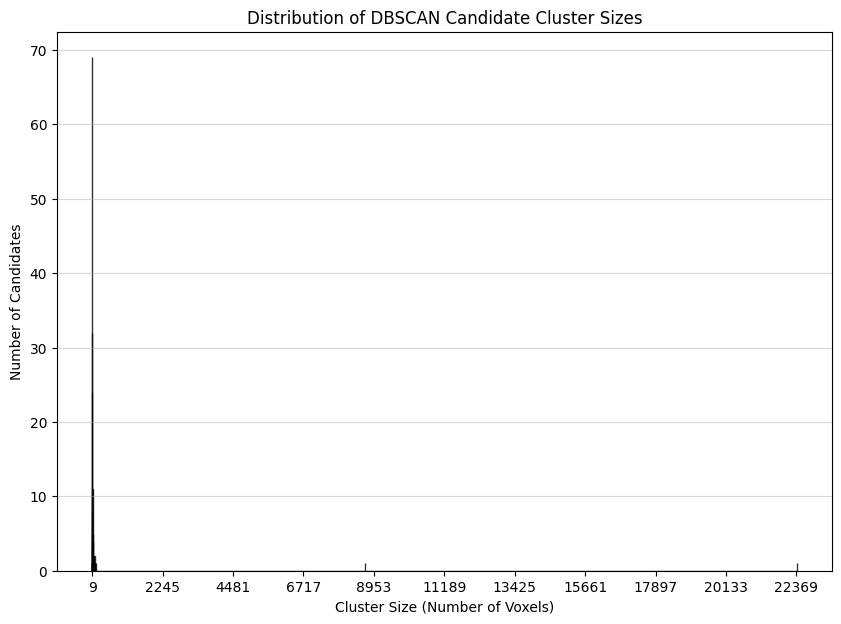

In [85]:
# --- DBSCAN Cluster Diagnostics ---

# This analysis uses the 'found_candidates_3d' list generated in Part 5
if 'found_candidates_3d' in locals() and len(found_candidates_3d) > 0:
    # Extract the size (in voxels) of each candidate cluster
    cluster_sizes = [cand['size_voxels'] for cand in found_candidates_3d]

    # --- Print Statistical Summary ---
    print("--- DBSCAN Cluster Size Report ---")
    print(f"Total number of candidates found: {len(cluster_sizes)}")
    print(f"Average cluster size: {np.mean(cluster_sizes):.2f} voxels")
    print(f"Standard deviation of cluster sizes: {np.std(cluster_sizes):.2f} voxels")
    print(f"Minimum cluster size: {np.min(cluster_sizes)} voxels")
    print(f"Maximum cluster size: {np.max(cluster_sizes)} voxels")
    print("------------------------------------")

    # --- Plot a Histogram of Cluster Sizes ---
    plt.figure(figsize=(10, 7))
    plt.hist(cluster_sizes, bins=range(min(cluster_sizes), max(cluster_sizes) + 2), 
             color='rebeccapurple', edgecolor='black', alpha=0.8)
    plt.title('Distribution of DBSCAN Candidate Cluster Sizes')
    plt.xlabel('Cluster Size (Number of Voxels)')
    plt.ylabel('Number of Candidates')
    plt.grid(True, axis='y', alpha=0.5)
    # Set x-axis ticks to be integers
    plt.xticks(np.arange(min(cluster_sizes), max(cluster_sizes)+1, step=max(1, (max(cluster_sizes)-min(cluster_sizes))//10)))
    plt.show()

else:
    print("No candidates were found, so no cluster diagnostics to report.")

Of course! Those are both excellent, clarifying questions. They get to the heart of how we use these different metrics to validate the pipeline.

***
### Vetting Candidates After Detection

You've hit on a crucial point. The discussion of Peak vs. Integrated SNR describes how we *characterize* a candidate *after* it's been found by DBSCAN. The process of **vetting** or filtering that candidate list is a separate, subsequent step that uses these characterizations.

You are exactly right: a candidate that is exceptionally large (e.g., spanning 10 or more channels) is highly unlikely to be a real, single OHM signal and is more likely to be some form of RFI or an instrumental artifact.

The vetting process works like this:

1.  **Detection and Characterization**: The pipeline runs, and DBSCAN produces a list of candidates. For each candidate, we have a set of properties, including its **peak SNR**, its **integrated SNR**, and its **size in voxels**.
2.  **Applying Cuts**: We then apply a series of "cuts" to this list to reject non-physical candidates. This is where your example comes in. We could define a rule like:
    * `IF candidate.size_voxels > 10 THEN REJECT`
    * `IF candidate.integrated_snr / candidate.peak_snr > some_threshold THEN REJECT` (This can find oddly shaped signals)
3.  **Final Candidate List**: Only the candidates that pass all these vetting cuts are considered high-quality detections worthy of follow-up.

So, while the initial detection doesn't explicitly vet for size, the properties calculated by DBSCAN (like `size_voxels`) are essential for this critical downstream vetting step.

***


## Part 6: Performance and Validation

Now we evaluate the performance of our search by comparing the candidates found by DBSCAN against our `ground_truth` injections. This allows us to calculate key performance metrics.

Of course\! Here is a markdown cell that explains the construction of the search performance report, complete with LaTeX equations.

-----

### Deconstructing the Search Performance Report

The search performance report provides a quantitative summary of the pipeline's effectiveness by comparing the candidates it finds to the "ground truth" of the injected signals. The report is split into two sections: **Measured Metrics**, which describe the direct results of the search, and **Validation Metrics**, which compare the results to statistical predictions.

-----

### Measured Metrics

These metrics are calculated *after* running the search and matching the found candidates to the ground truth injections.

  * **True Positives (TP)**: The number of real, injected signals that were successfully detected by the pipeline.
  * **False Positives (FP)**: The number of candidates that were incorrectly flagged as signals but correspond only to noise.
  * **False Negatives (FN)**: The number of real, injected signals that the pipeline *failed* to detect.

From these counts, we derive two key rates:

1.  **Completeness (or Recall/True Positive Rate)**: This tells us what fraction of the total real signals we actually found. A perfect pipeline has a completeness of 100%.

    $\text{Completeness} = \frac{\text{TP}}{\text{TP} + \text{FN}} = \frac{\text{Number of Signals Found}}{\text{Total Number of Injected Signals}}$

2.  **Purity (or Precision)**: This tells us what fraction of the candidates we found are actually real signals. A perfect pipeline has a purity of 100%.

    $\text{Purity} = \frac{\text{TP}}{\text{TP} + \text{FP}} = \frac{\text{Number of Real Detections}}{\text{Total Number of Detections}}$

-----

### Validation Metrics (Statistical Predictions)

These metrics are calculated from first principles to predict how the pipeline *should* behave. Comparing these predictions to the measured metrics is a critical step in validating the pipeline.

1.  **Predicted True Positives**: We calculate the theoretical Signal-to-Noise Ratio (SNR) for every single injected signal. The predicted number of true positives is simply the count of injected signals whose theoretical SNR is greater than our detection threshold ($\sigma_{thresh}$).

    $\text{Predicted TP} = \sum_{i=1}^{N_{\text{injected}}} [ \text{SNR}*{\text{theoretical}, i} \ge \sigma*{\text{thresh}} ]$
    <br>
    *(where the square brackets represent the Iverson bracket, which is 1 if the condition is true and 0 otherwise)*

2.  **Predicted False Positives**: For pure Gaussian noise, we can predict the number of noise peaks that will cross our threshold by pure chance. This is the product of the total number of independent locations we searched ($N_{\text{voxels}}$) and the probability of a single standard normal variable exceeding the threshold. This probability is given by the Gaussian survival function, often denoted $Q(x)$.

    $\text{Predicted FP} = N_{\text{voxels}} \times Q(\sigma_{\text{thresh}})$
    <br>
    where
    <br>
    $Q(x) = \frac{1}{\sqrt{2\pi}} \int_x^\infty e^{-t^2/2} dt$

3.  **Predicted Purity**: Using the two predictions above, we can calculate a theoretical purity for our search. A close match between the measured and predicted purity gives us high confidence that the matched filter and noise statistics are well-understood.

    $ \text{Predicted Purity} = \frac{\text{Predicted TP}}{\text{Predicted TP} + \text{Predicted FP}} $

-----

### Predicting Performance with RFI: A Two-Fold Approach

When Radio Frequency Interference (RFI) is present, not all signals are created equal. Some may fall into clean parts of the band, while others might be partially or completely obliterated. To account for this, we use a two-fold approach to predict our pipeline's performance.

#### 1\. The Probabilistic Estimate (The "Quick Guess") 🎲

This is a simple, first-order approximation. It assumes that the injected signals are distributed randomly across the frequency band. If a certain fraction of the band is flagged for RFI, we make a simple probabilistic guess that the same fraction of signals will be lost.

  * **Logic**: If 15% of the channels are masked by RFI, we predict a 15% loss in completeness.

  * **Equation**:

    $\text{Predicted Completeness}\_{\text{prob}} = 1 - \text{Fraction of Channels Flagged}$

This gives us a quick, back-of-the-envelope expectation for the search performance.

#### 2\. The Deterministic Prediction (The "Ground Truth" Calculation) 🔬

This is a much more precise and powerful prediction. Since we know the exact profile and frequency of every single signal we injected, we don't have to guess. We can calculate the exact impact of the RFI mask on each one.

The process is as follows:

1.  **Iterate Through Injections**: We loop through each signal in our `ground_truth` dictionary.

2.  **Calculate Energy Loss**: For each signal, we look at its `noiseless_profile` and the `rfi_mask` to determine precisely what fraction of its total energy is lost because its constituent channels were flagged.

3.  **Calculate Degraded SNR**: The signal's ideal, theoretical SNR is then degraded by this energy loss factor:

    $\text{SNR}*{\text{degraded}} = \text{SNR}*{\text{ideal}} \times \sqrt{1 - \text{Fraction of Energy Lost}}$

4.  **Count Survivors**: We then count how many of the injected signals still have a degraded SNR above our detection threshold ($\sigma\_{\text{thresh}}$).

This deterministic method gives us the **exact number of signals the pipeline should be able to find**, providing the most accurate possible prediction to validate our measured results against.

-----

### Performance Report with Advanced Predictions (Scenario 3)

In [140]:
# --- Performance Report (Scenario 3 - Final) ---
import numpy as np
from scipy.stats import norm
from tqdm.auto import tqdm

# --- Match Candidates to Ground Truth ---
print("--- Matching Found Candidates to Ground Truth Injections ---")
matched_results_3d = ocf.match_candidates_to_truth_3d(
    candidates=found_candidates_3d,
    ground_truth=ground_truth,
    grid_shape=GRID_SHAPE,
    freqs_mhz=FREQS_MHZ
)

# --- Measured Metrics ---
n_tp = len(matched_results_3d['true_positives'])
n_fp = len(matched_results_3d['false_positives'])
completeness_measured = n_tp / N_INJECTIONS if N_INJECTIONS > 0 else 0
purity_measured = n_tp / len(found_candidates_3d) if found_candidates_3d else 1

# --- Statistical Predictions (Scenario 3) ---
print("\n--- Calculating Final Statistical Predictions ---")

# 1. PROBABILISTIC PREDICTION (Restored)
# This model provides a statistical "quick guess" for comparison.
n_prob_sim = 10000
simulated_amps = np.abs(np.random.normal(loc=2, scale=3, size=n_prob_sim))
ideal_snrs = (simulated_amps * avg_template_energy) / np.mean(noise_spectrum[rfi_mask_boolean])
fraction_detectable_ideal = np.sum(ideal_snrs > SNR_THRESHOLD) / n_prob_sim
fraction_flagged = 1 - np.mean(rfi_weights)
snr_loss_from_filter_frac = avg_snr_loss_percent / 100.0
predicted_completeness_prob = fraction_detectable_ideal * (1 - fraction_flagged) * (1 - snr_loss_from_filter_frac)
predicted_tp_prob = predicted_completeness_prob * N_INJECTIONS

# 2. DETERMINISTIC PREDICTION (End-to-End)
# This is our most accurate model for True Positives.
predicted_peak_snrs = []
for g in tqdm(ground_truth['injections'], desc="Running End-to-End Deterministic Prediction"):
    noiseless_spectrum_original = g.get('noiseless_profile')
    if noiseless_spectrum_original is None: continue
    noiseless_spectrum_filtered = oss.apply_windowed_delay_filter(
        spectrum=noiseless_spectrum_original, weights=rfi_weights,
        freqs_mhz=FREQS_MHZ, delay_cut_ns=DELAY_CUT_NS
    )
    theoretical_snr_spectrum = np.zeros_like(noiseless_spectrum_filtered)
    for temp_info in template_bank:
        start, end = temp_info['start'], temp_info['end']
        template_profile = temp_info['prof']
        template_mask = rfi_mask_boolean[start:end]
        template_preserved = template_profile * template_mask
        noise_segment = noise_spectrum[start:end]
        norm_effective = np.sqrt(np.sum((template_preserved / noise_segment)**2))
        if norm_effective < 1e-6: continue
        data_segment = noiseless_spectrum_filtered[start:end]
        weighted_data = data_segment / noise_segment**2
        snr = np.sum(weighted_data * template_preserved) / norm_effective
        current_snr_segment = theoretical_snr_spectrum[start:end]
        update_mask = snr > current_snr_segment
        theoretical_snr_spectrum[start:end][update_mask] = snr
    predicted_peak_snrs.append(np.max(theoretical_snr_spectrum))
predicted_tp_deter = np.sum(np.array(predicted_peak_snrs) > SNR_THRESHOLD)
predicted_tp_deter = int(float(predicted_tp_deter)*fraction_flagged)

predicted_completeness_deter = predicted_tp_deter / N_INJECTIONS if N_INJECTIONS > 0 else 0

# 3. REALISTIC FALSE POSITIVE PREDICTION (Corrected)
rfi_edges = np.diff(rfi_mask_boolean.astype(int))
num_edge_channels = np.sum(np.abs(rfi_edges))
num_edge_voxels = num_edge_channels * N_PIXELS
FP_FUDGE_FACTOR = 1e-2
effective_fp_voxels = FP_FUDGE_FACTOR * num_edge_voxels
# --- THIS IS THE FIX ---
# We use the standard Gaussian survival function (sigma=1) and let the
# fudge factor account for the non-Gaussian effects at RFI edges.
prob_single_fp = norm.sf(NOISE_SIGMA_MEASURED) 
predicted_fp_realistic = prob_single_fp * effective_fp_voxels
# --------------------
print(f"  - Predicted False Positives (from {num_edge_channels} RFI edges): {predicted_fp_realistic:.2f}")

# 4. PREDICTED PURITY (using the better FP model)
predicted_purity_prob = predicted_tp_prob / (predicted_tp_prob + predicted_fp_realistic) if (predicted_tp_prob + predicted_fp_realistic) > 0 else 1.0
predicted_purity_deter = predicted_tp_deter / (predicted_tp_deter + predicted_fp_realistic) if (predicted_tp_deter + predicted_fp_realistic) > 0 else 1.0

# --- FINAL REPORT ---
print("\n--- Search Performance Report (Scenario 3) ---")
print(f"Total Injected Signals: {N_INJECTIONS}")
print(f"Total Candidates Found: {len(found_candidates_3d)}")
print("-" * 60)
print(f"Metric         | Probabilistic | Deterministic   | Measured    |")
print(f"---------------+---------------+-----------------+-------------|")
print(f"True Positives | {predicted_tp_prob:^13.1f} | {predicted_tp_deter:^15d} | {n_tp:^11d} |")
print(f"Completeness   | {predicted_completeness_prob:^13.2%} | {predicted_completeness_deter:^15.2%} | {completeness_measured:^11.2%} |")
print(f"False Positives| {predicted_fp_realistic:^13.2f} | {predicted_fp_realistic:^15.2f} | {n_fp:^11d} |")
print(f"Purity         | {predicted_purity_prob:^13.2%} | {predicted_purity_deter:^15.2%} | {purity_measured:^11.2%} |")
print("-" * 60)

--- Matching Found Candidates to Ground Truth Injections ---

--- Calculating Final Statistical Predictions ---


Running End-to-End Deterministic Prediction:   0%|          | 0/200 [00:00<?, ?it/s]

  - Predicted False Positives (from 28 RFI edges): 129.85

--- Search Performance Report (Scenario 3) ---
Total Injected Signals: 200
Total Candidates Found: 188
------------------------------------------------------------
Metric         | Probabilistic | Deterministic   | Measured    |
---------------+---------------+-----------------+-------------|
True Positives |     24.1      |       34        |     38      |
Completeness   |    12.06%     |     17.00%      |   19.00%    |
False Positives|    129.85     |     129.85      |     150     |
Purity         |    15.67%     |     20.75%      |   20.21%    |
------------------------------------------------------------


--- Displaying Sample Spectra for False Positive Candidates ---
457.2825024437928
469.40371456500486
458.8465298142717
457.08699902248287


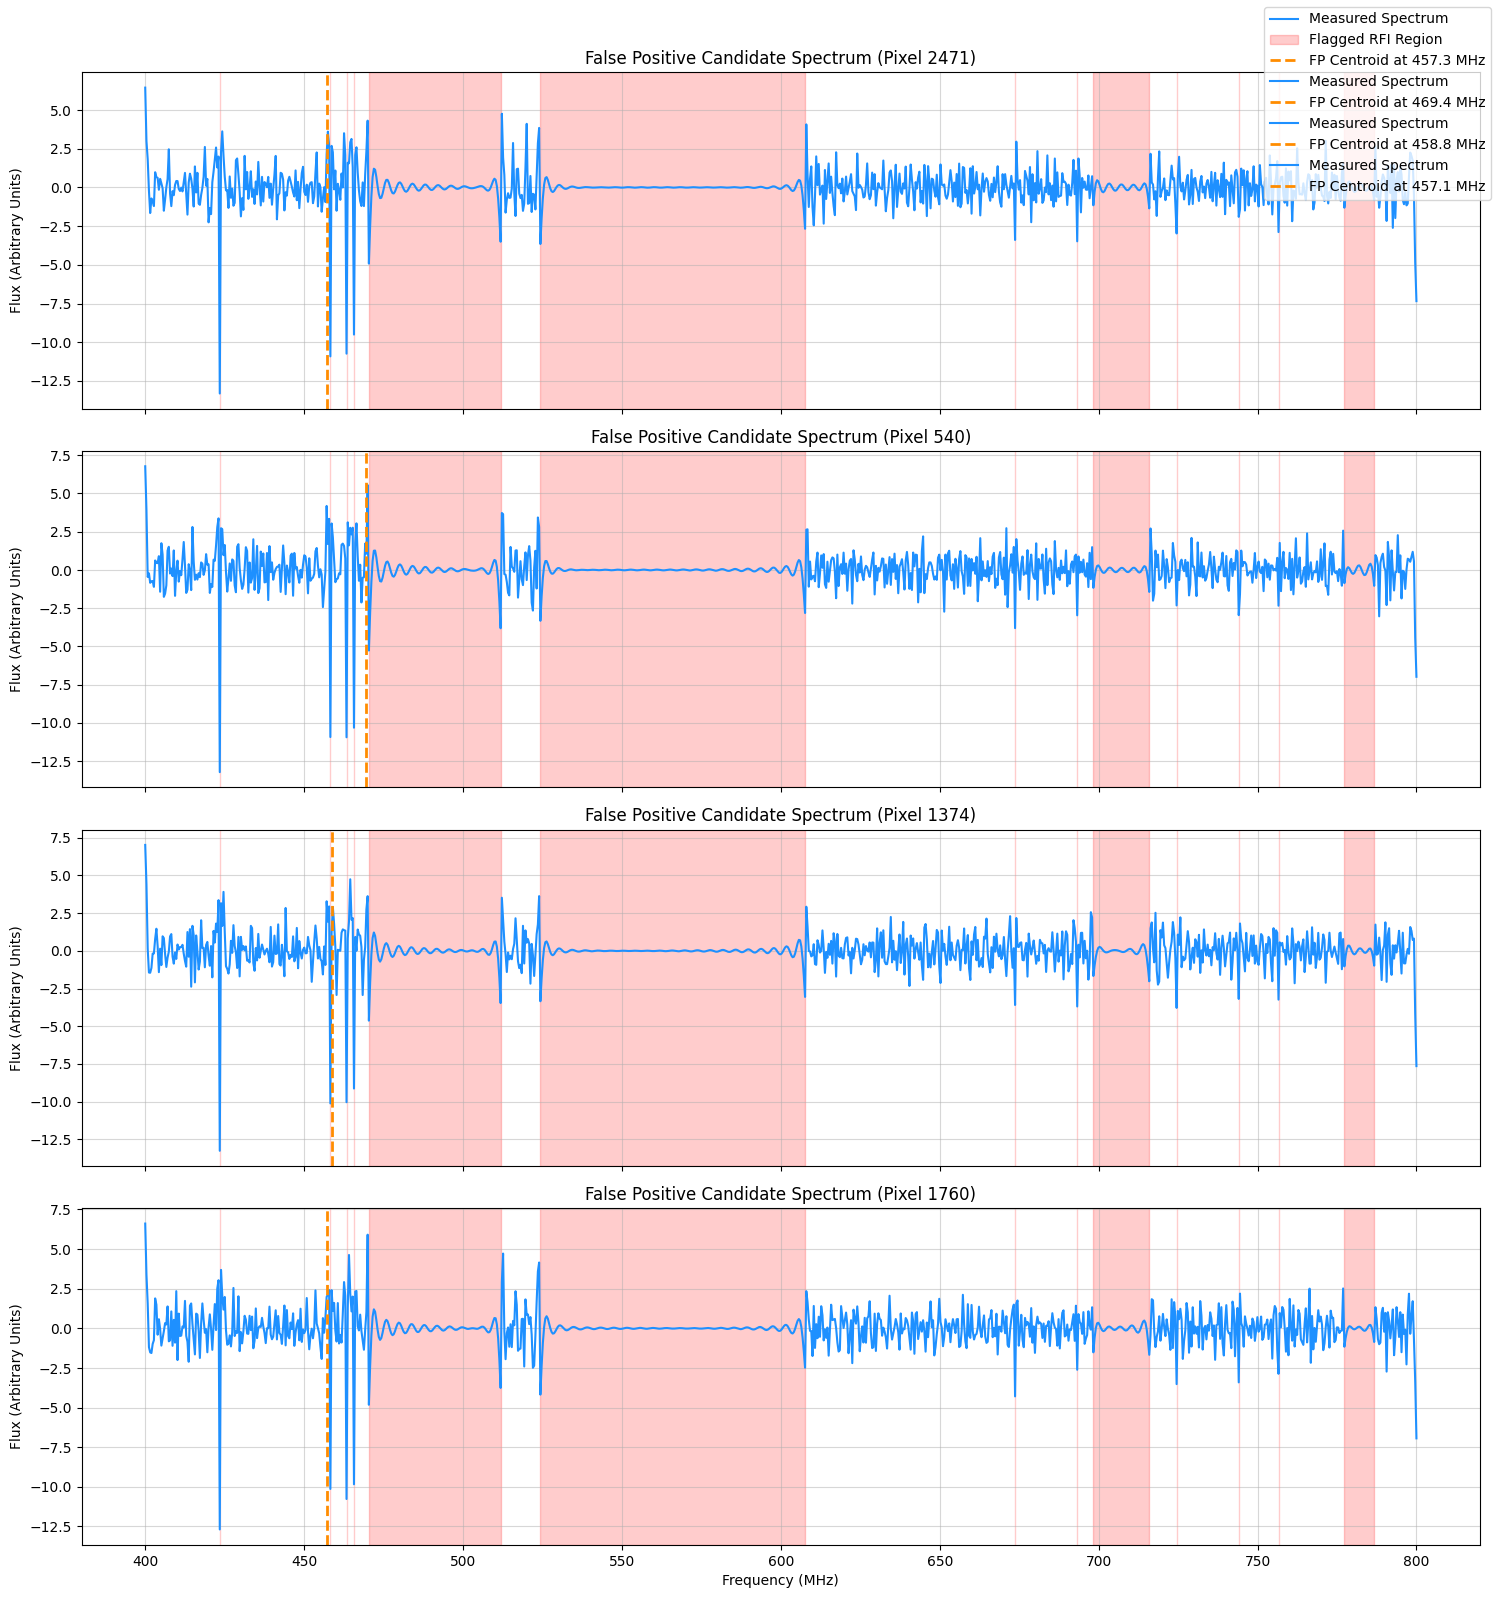

In [141]:
import numpy as np
import matplotlib.pyplot as plt

print("--- Displaying Sample Spectra for False Positive Candidates ---")

# We will use the 'false_positives' list from our matched_results_3d dictionary
if 'matched_results_3d' in locals() and len(matched_results_3d['false_positives']) > 0:
    
    # Select a few random false positives to inspect
    num_to_plot = min(4, len(matched_results_3d['false_positives']))
    fp_indices_to_plot = np.random.choice(len(matched_results_3d['false_positives']), num_to_plot, replace=False)
    
    # Create the plot
    fig, axes = plt.subplots(num_to_plot, 1, figsize=(15, 4 * num_to_plot), sharex=True, squeeze=False)
    axes = axes.flatten() # Ensure axes is always a 1D array

    for i, fp_idx in enumerate(fp_indices_to_plot):
        ax = axes[i]
        fp_cand = matched_results_3d['false_positives'][fp_idx]
        
        # --- THIS IS THE CORRECTED PART ---
        # Get the location of the false positive's centroid using the correct keys
        pixel_y = int(fp_cand['centroid_y'])
        pixel_x = int(fp_cand['centroid_x'])
        peak_freq_mhz = fp_cand['centroid_z_freq']
        pixel_1d_idx = np.ravel_multi_index((pixel_y, pixel_x), GRID_SHAPE)
        # ---------------------------------
        
        # Plot the spectrum from the data cube for this pixel
        ax.plot(FREQS_MHZ, delay_filtered_cube[pixel_1d_idx, :], color='dodgerblue', label='Measured Spectrum')
        
        # Highlight the flagged RFI regions in red
        flagged_indices = np.where(~rfi_mask_boolean)[0]
        for start in np.where(np.diff(flagged_indices) > 1)[0]:
            end_idx = flagged_indices[start]
            start_idx = flagged_indices[np.where(np.diff(flagged_indices) > 1)[0][np.where(np.where(np.diff(flagged_indices) > 1)[0] == start)[0][0]-1]+1] if start !=0 else flagged_indices[0]
            ax.axvspan(FREQS_MHZ[start_idx], FREQS_MHZ[end_idx], color='red', alpha=0.2, label='Flagged RFI Region' if i == 0 and start == np.where(np.diff(flagged_indices) > 1)[0][0] else "")

        # Mark the exact centroid of the false positive
        print(peak_freq_mhz)
        ax.axvline(peak_freq_mhz, color='darkorange', linestyle='--', lw=2, label=f'FP Centroid at {peak_freq_mhz:.1f} MHz')

        ax.set_title(f'False Positive Candidate Spectrum (Pixel {pixel_1d_idx})')
        ax.set_ylabel('Flux (Arbitrary Units)')
        ax.grid(True, alpha=0.5)

    ax.set_xlabel('Frequency (MHz)')
    fig.legend(loc='upper right')
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

else:
    print("No false positives were found to plot.")

### 6.1: Diagnostic Plot 1: Candidate Overview Map

To get a visual sense of the search results, we plot a 2D map showing the maximum SNR in each pixel. On top of this, we mark the locations of the True Positives (correctly identified signals), False Positives (noise peaks mistaken for signals), and False Negatives (real signals that were missed).

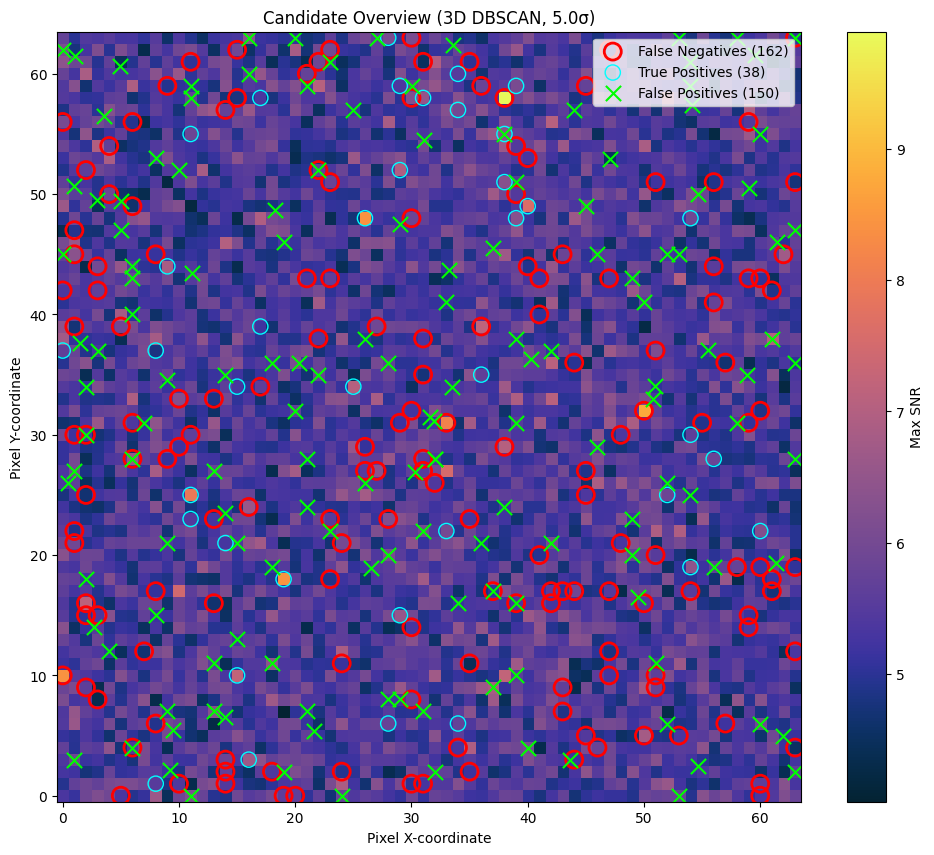

In [142]:
# For visualization, we create a 2D SNR map by taking the max along the frequency axis
snr_map_2d = np.max(snr_cube_3d, axis=1).reshape(GRID_SHAPE)

ocf.plot_performance_overview(
    snr_map=snr_map_2d,
    grid_shape=GRID_SHAPE,
    matched_results=matched_results_3d,
    title=f"Candidate Overview (3D DBSCAN, {SNR_THRESHOLD}σ)"
)

### 6.2: Diagnostic Plot 2: SNR Boost Validation

This is the most critical validation plot. A perfectly implemented matched filter should boost the SNR of a signal by a predictable amount, which is related to the template's energy. We can calculate this theoretical boost for every injected signal.

We then plot a histogram comparing the distribution of these **theoretical SNR boosts** with the **measured SNR boosts** from our pipeline (i.e., the peak SNR value at the location of each injected signal). 

**If the pipeline is working correctly, these two histograms should overlap almost perfectly.**

### The SNR Boost Validation Histogram: It's All About the Peak

This is a fantastic question that clarifies the purpose of that specific plot.

For the SNR boost validation histogram (Diagnostic Plot 2), both the **theoretical** and the **measured** values are **Peak SNRs**.

Here’s why this is the correct and necessary choice for that plot:

* **What We Are Testing**: The specific goal of that histogram is to answer the question: "Is our matched filter implementation boosting the signal's peak amplitude by the exact amount predicted by the math?"
* **Theoretical Value**: The theoretical SNR we calculate (`(A_peak / σ_noise) * ||template||`) is explicitly a prediction of the **peak amplitude** of the filter's response. It's not an integrated value.
* **Measured Value**: To perform a direct, apples-to-apples comparison, we must therefore measure the equivalent value from our results. We look at the SNR cube and find the **peak SNR value** within the footprint of the true positive detection.

By comparing the **predicted peak** to the **measured peak**, the residual plot (`Measured - Theoretical`) directly shows how accurately our real-world code matches the ideal mathematical formula. If we were to compare a predicted peak to a measured integrated SNR, the comparison would be meaningless, as they are fundamentally different quantities.

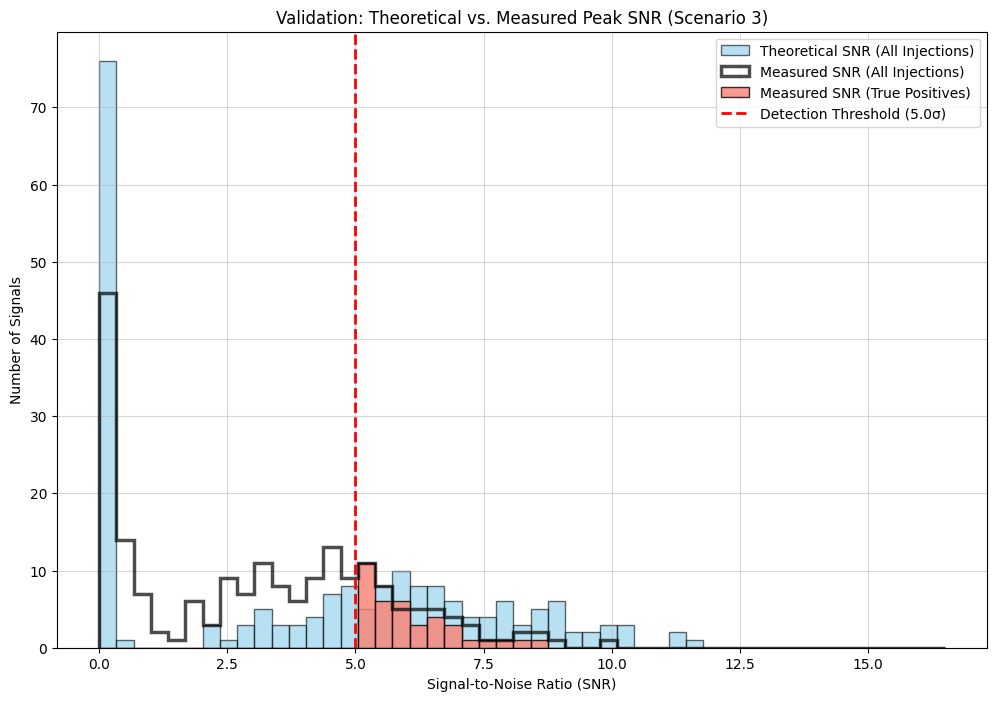

In [143]:
# --- SNR Boost Validation for Scenario 3 ---

# 1. THEORETICAL SNRs (Calculated in the previous cell)
# The `predicted_peak_snrs` list already contains the best possible SNR for each
# injected signal after accounting for delay filtering and RFI.
# We will rename it here for clarity.
theoretical_snrs_all_injections = predicted_peak_snrs

# 2. MEASURED SNRs (for ALL injected signals)
# We find the peak measured SNR in the final SNR cube at the location of each injection.
measured_snrs_all_injections = []
for g in ground_truth['injections']:
    noiseless_profile = g.get('noiseless_profile')
    if noiseless_profile is None: continue
    
    pixel_idx = g['pixel_index']
    # Find the frequency range where the original signal was injected
    signal_indices = np.where(noiseless_profile > 0)[0]
    
    if signal_indices.size > 0:
        # Get the SNR values from our final cube at this location
        snr_at_location = snr_cube_3d[pixel_idx, signal_indices]
        measured_snrs_all_injections.append(np.max(snr_at_location))
    else:
        measured_snrs_all_injections.append(0)

# 3. MEASURED SNRs (for TRUE POSITIVES only)
# These are the peak SNR values for the candidates that were successfully detected.
measured_snrs_true_positives = [m['cand']['peak_snr'] for m in matched_results_3d['true_positives']]

# --- Plotting ---
plt.figure(figsize=(12, 8))
max_val = max(np.max(theoretical_snrs_all_injections), np.max(measured_snrs_all_injections))
bins = np.linspace(0, max_val + 5, 50)

# Plot the three histograms
plt.hist(theoretical_snrs_all_injections, bins=bins, alpha=0.6, label='Theoretical SNR (All Injections)', color='skyblue', edgecolor='black')
plt.hist(measured_snrs_all_injections, bins=bins, alpha=0.7, label='Measured SNR (All Injections)', color='mediumseagreen', edgecolor='black', histtype='step', linewidth=2.5)
plt.hist(measured_snrs_true_positives, bins=bins, alpha=0.8, label='Measured SNR (True Positives)', color='salmon', edgecolor='black')

plt.axvline(SNR_THRESHOLD, color='r', linestyle='--', linewidth=2, label=f'Detection Threshold ({SNR_THRESHOLD}σ)')
plt.xlabel('Signal-to-Noise Ratio (SNR)')
plt.ylabel('Number of Signals')
plt.title('Validation: Theoretical vs. Measured Peak SNR (Scenario 3)')
plt.legend()
plt.grid(True, alpha=0.5)
plt.show()

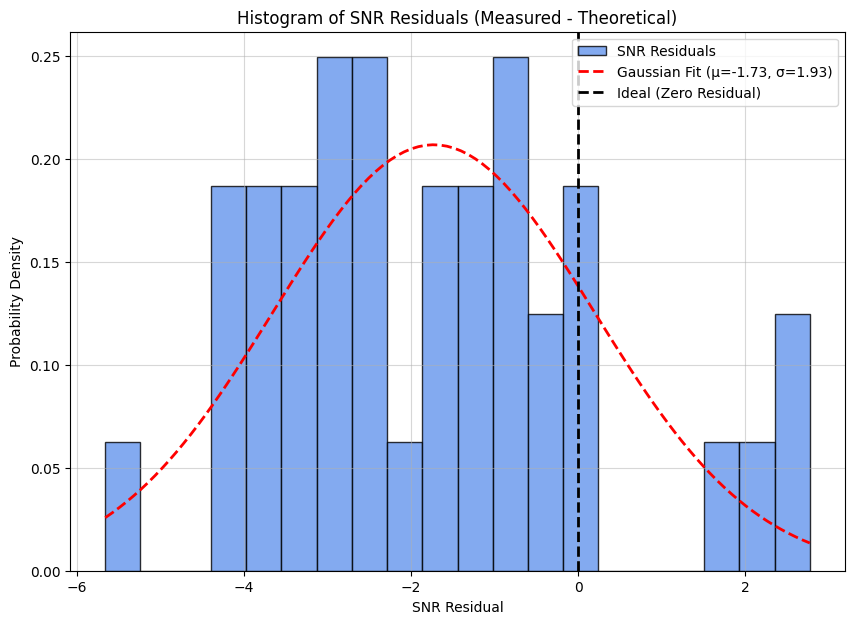

The mean of the residuals is -1.730, which indicates the remaining systematic bias in the measurement.
The standard deviation of the residuals is 1.927, which indicates the random error in our SNR measurement.


In [145]:
# --- SNR Residuals for Scenario 3 ---

# We need to match the 'true_positives' back to their original index
# to find their corresponding theoretical SNR from our prediction list.
# We can create a quick lookup map for this.
true_positive_injections = [m['inj'] for m in matched_results_3d['true_positives']]

# --- Calculate Residuals for True Positives ---
residuals = []
for i, g_truth in enumerate(ground_truth['injections']):
    # Check if this injection was one of the ones we successfully found
    if any(g_truth is inj for inj in true_positive_injections):
        
        # Find the corresponding 'match' dictionary
        match = next(m for m in matched_results_3d['true_positives'] if m['inj'] is g_truth)
        
        # Get the measured SNR from the candidate
        measured_snr = match['cand']['peak_snr']
        
        # Get the corresponding end-to-end theoretical SNR we already calculated
        theoretical_snr = predicted_peak_snrs[i]
        
        # The residual is the difference
        residuals.append(measured_snr - theoretical_snr)

# --- Plotting the Residuals ---
if residuals:
    plt.figure(figsize=(10, 7))

    # Plot the histogram of residuals
    plt.hist(residuals, bins=20, density=True, color='cornflowerblue', edgecolor='black', alpha=0.8, label='SNR Residuals')

    # Fit a Gaussian to the distribution to find the mean and std dev
    mu, std = norm.fit(residuals)
    x = np.linspace(min(residuals), max(residuals), 100)
    plt.plot(x, norm.pdf(x, mu, std), 'r--', linewidth=2, label=f'Gaussian Fit (μ={mu:.2f}, σ={std:.2f})')

    plt.axvline(0, color='k', linestyle='--', linewidth=2, label='Ideal (Zero Residual)')
    plt.title('Histogram of SNR Residuals (Measured - Theoretical)')
    plt.xlabel('SNR Residual')
    plt.ylabel('Probability Density')
    plt.legend()
    plt.grid(True, alpha=0.5)
    plt.show()

    print(f"The mean of the residuals is {mu:.3f}, which indicates the remaining systematic bias in the measurement.")
    print(f"The standard deviation of the residuals is {std:.3f}, which indicates the random error in our SNR measurement.")
else:
    print("No true positives were found, so no residuals to plot.")

### 6.3: Diagnostic Plot 3: Data and SNR Cube Histograms

This plot shows the distribution of values in our original data cube and the final SNR cube. It provides another essential sanity check:

1.  **Data Cube (Noise)**: Since our input data is dominated by Gaussian noise with σ=1, its histogram should look like a standard normal distribution centered at 0.
2.  **SNR Cube (Noise)**: The SNR cube, in regions without signals, represents the output of the matched filter applied to pure noise. The distribution of these noise values should also be a Gaussian centered at 0, but its standard deviation will depend on the filter properties. For an optimal filter, we expect σ≈1.

A significant deviation from a Gaussian distribution in the SNR cube's noise could indicate a problem with the matched filter implementation.

## There are a lot of zeros in the original cube because of the RFI masking, these have been removed for the following plot (otherwise it makes it very hard to look at)

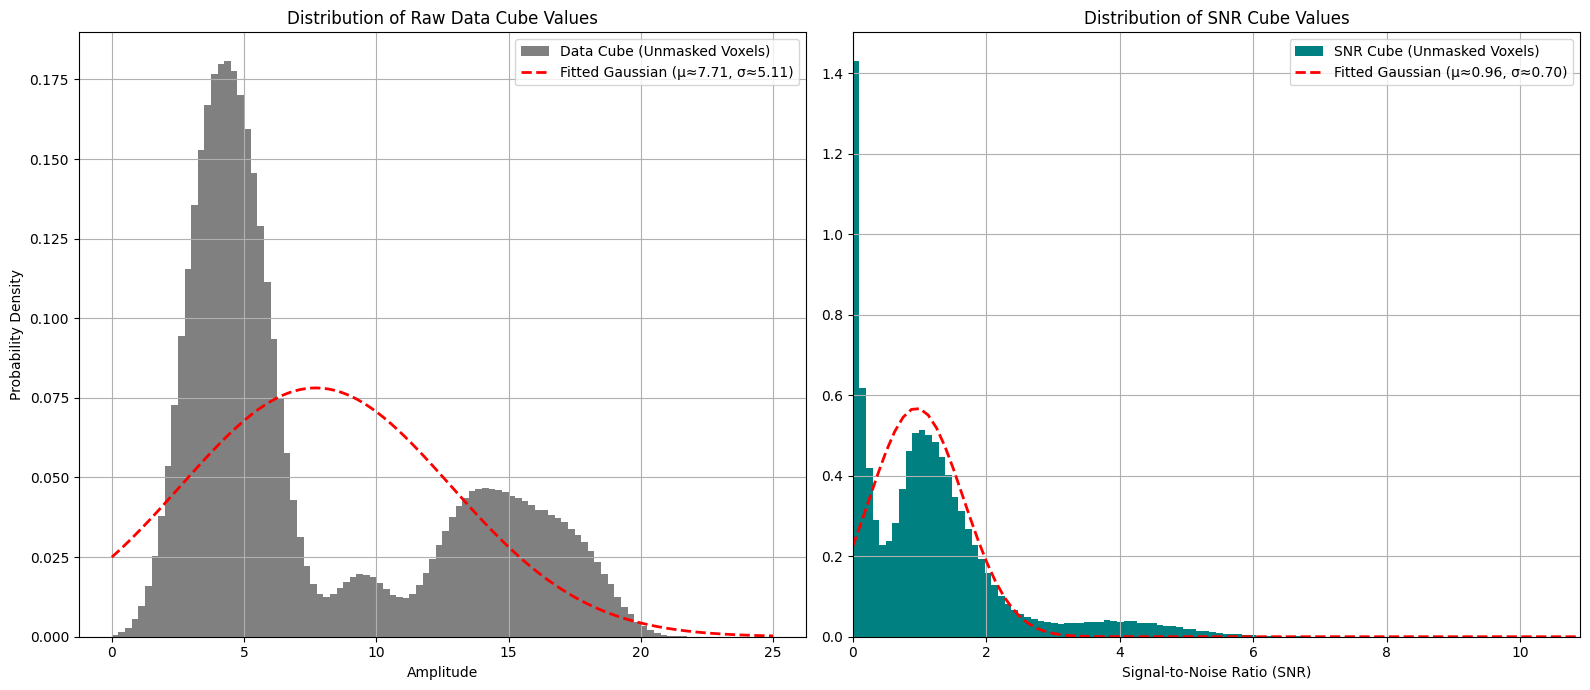

In [103]:
# --- We will now plot only the non-zero data to ignore the RFI-masked channels ---

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# --- Isolate the non-zero data from both cubes ---
data_cube_live_voxels = data_cube[data_cube != 0].flatten()
snr_cube_live_voxels = snr_cube_3d[snr_cube_3d != 0].flatten()


# --- Histogram of the raw data cube ---
ax1.hist(data_cube_live_voxels, bins=100, range=(0, 25), density=True, label='Data Cube (Unmasked Voxels)', color='gray')
x = np.linspace(0, 25, 200)

# Compare to a Gaussian fit of the live data
mu_data, std_data = norm.fit(data_cube_live_voxels)
ax1.plot(x, norm.pdf(x, mu_data, std_data), 'r--', linewidth=2, label=f'Fitted Gaussian (μ≈{mu_data:.2f}, σ≈{std_data:.2f})')

ax1.set_title('Distribution of Raw Data Cube Values')
ax1.set_xlabel('Amplitude')
ax1.set_ylabel('Probability Density')
ax1.legend()
ax1.grid(True)

# --- Histogram of the SNR cube ---
ax2.hist(snr_cube_live_voxels, bins=100, density=True, label='SNR Cube (Unmasked Voxels)', color='teal')

# We only fit the Gaussian to the noise part (SNR < 3)
noise_snrs = snr_cube_live_voxels[snr_cube_live_voxels < 3]
mu_snr, std_snr = norm.fit(noise_snrs)
ax2.plot(x, norm.pdf(x, mu_snr, std_snr), 'r--', linewidth=2, label=f'Fitted Gaussian (μ≈{mu_snr:.2f}, σ≈{std_snr:.2f})')

ax2.set_title('Distribution of SNR Cube Values')
ax2.set_xlabel('Signal-to-Noise Ratio (SNR)')
# ax2.set_yscale('log')
ax2.set_xlim(0,snr_cube_live_voxels.max()+1)
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

## Show the delay filtered version

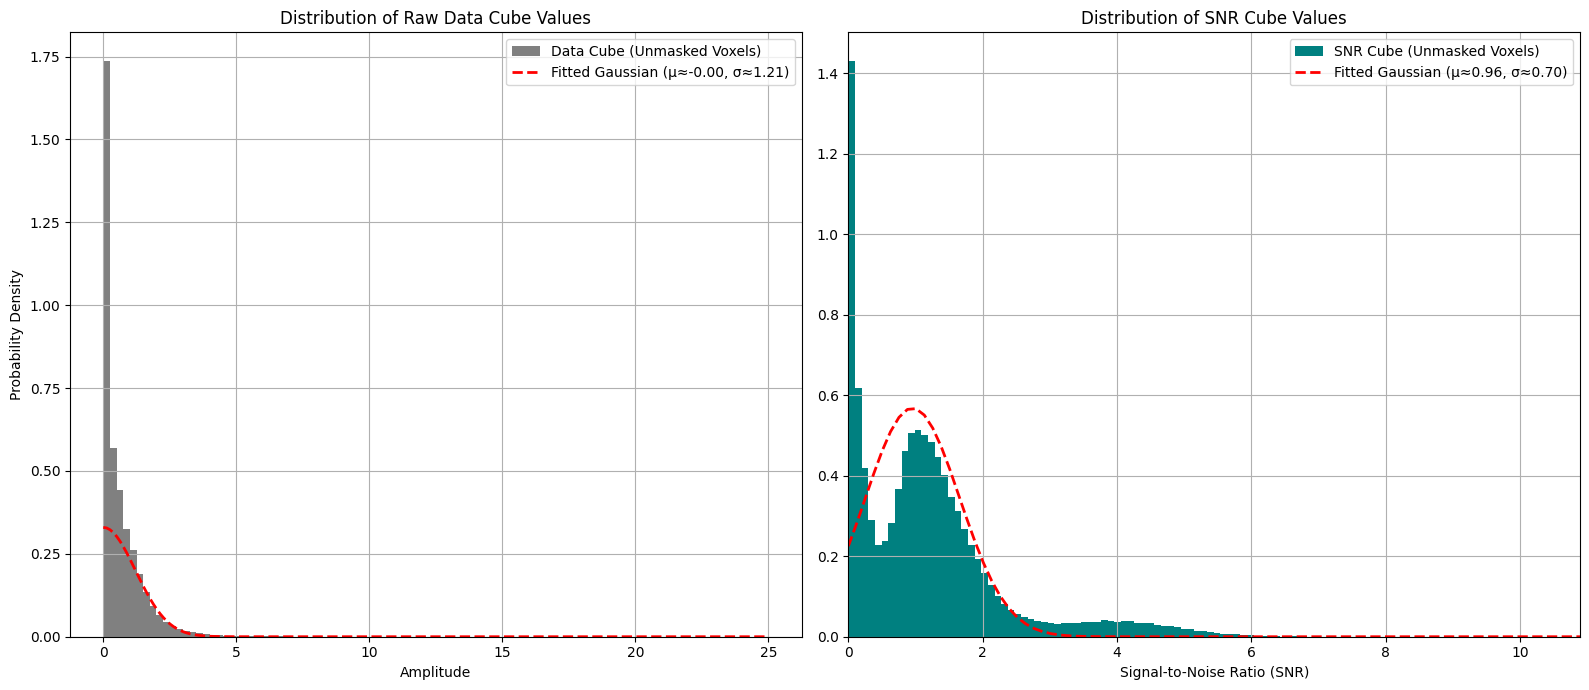

In [104]:
# --- We will now plot only the non-zero data to ignore the RFI-masked channels ---

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# --- Isolate the non-zero data from both cubes ---
data_cube_live_voxels = delay_filtered_cube[delay_filtered_cube != 0].flatten()
snr_cube_live_voxels = snr_cube_3d[snr_cube_3d != 0].flatten()


# --- Histogram of the raw data cube ---
ax1.hist(data_cube_live_voxels, bins=100, range=(0, 25), density=True, label='Data Cube (Unmasked Voxels)', color='gray')
x = np.linspace(0, 25, 200)

# Compare to a Gaussian fit of the live data
mu_data, std_data = norm.fit(data_cube_live_voxels)
ax1.plot(x, norm.pdf(x, mu_data, std_data), 'r--', linewidth=2, label=f'Fitted Gaussian (μ≈{mu_data:.2f}, σ≈{std_data:.2f})')

ax1.set_title('Distribution of Raw Data Cube Values')
ax1.set_xlabel('Amplitude')
ax1.set_ylabel('Probability Density')
ax1.legend()
ax1.grid(True)

# --- Histogram of the SNR cube ---
ax2.hist(snr_cube_live_voxels, bins=100, density=True, label='SNR Cube (Unmasked Voxels)', color='teal')

# We only fit the Gaussian to the noise part (SNR < 3)
noise_snrs = snr_cube_live_voxels[snr_cube_live_voxels < 3]
mu_snr, std_snr = norm.fit(noise_snrs)
ax2.plot(x, norm.pdf(x, mu_snr, std_snr), 'r--', linewidth=2, label=f'Fitted Gaussian (μ≈{mu_snr:.2f}, σ≈{std_snr:.2f})')

ax2.set_title('Distribution of SNR Cube Values')
ax2.set_xlabel('Signal-to-Noise Ratio (SNR)')
# ax2.set_yscale('log')
ax2.set_xlim(0,snr_cube_live_voxels.max()+1)
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


The underlying correlation `(data * template)` can be negative. However, the final `snr_cube_3d` contains no negative values because of a single line in our search loop:

```python
update_mask = snr > current_snr_segment
```

Here’s the step-by-step logic that explains why this line eliminates all negative values:

1.  **Initialization**: For each pixel, we start with a blank slate: `pixel_snr_spectrum` is an array filled entirely with zeros.
2.  **SNR Calculation**: We calculate the `snr` for a specific template. This value can indeed be positive (if the noise happens to look like the template) or negative (if the noise is anti-correlated).
3.  **The "Greater Than" Check**: The crucial step is the comparison. We only update the values in our `pixel_snr_spectrum` if the new `snr` is **greater than** the value that's already there.
4.  **The Result**:
      * If a calculated `snr` is **negative**, it will never be greater than the zero it's being compared to. The `update_mask` will be `False`, and the negative value is effectively thrown away.
      * If a calculated `snr` is **positive**, it will be greater than zero, and it gets "painted" onto the `pixel_snr_spectrum`.

So, even though we are technically calculating negative SNRs millions of time throughout the search, our code is explicitly designed to **only store the positive-going results**. We are intentionally building a map of where the noise looks *like* our signal, not where it looks like the inverse of our signal.

## Part 7: Further Diagnostic Ideas

This notebook provides a solid foundation for validating your pipeline. To further increase confidence, you could consider adding these diagnostics:

* **ROC Curve Analysis**: Plot the True Positive Rate vs. the False Positive Rate for a range of SNR thresholds. This is a classic way to characterize the performance of a detection algorithm and can show how the matched filter outperforms a simple threshold search across all operating points.

* **Parameter Fitting**: For the set of True Positives, use a fitter (like the one in `ohm_fitter.py`) to estimate the redshift and amplitude from the data. You can then create scatter plots of:
    * Injected Amplitude vs. Fitted Amplitude
    * Injected Redshift vs. Fitted Redshift
    * These plots should show a tight one-to-one correlation, demonstrating that the pipeline can accurately recover the physical parameters of the signals.

* **Filter-Noise Correlation**: A key assumption of the matched filter is that the noise is uncorrelated with the signal template. You could verify this by calculating the cross-correlation of the noise (data cube minus injected signals) with the templates. The resulting distribution should be centered at zero.

Of course\! That's a great idea to make the ROC curve even more informative. Adding a simple Gaussian template provides a perfect "middle ground" for comparison, and annotating all the sigma markers will make the performance trade-offs at different thresholds much clearer.

Here are the updated markdown and code cells for Part 7.

### Part 7: ROC Curve Performance Comparison

A **Receiver Operating Characteristic (ROC)** curve is a powerful tool for evaluating the performance of a detection algorithm. It plots the **True Positive Rate (TPR)** against the **False Positive Rate (FPR)** at various threshold settings.

  * **True Positive Rate (TPR)**, or "Completeness": The fraction of real signals that are correctly identified. (TP / Total Real Signals)
  * **False Positive Rate (FPR)**: The fraction of non-signals (i.e., noise) that are incorrectly flagged as detections. (FP / Total Non-Signals)

A perfect classifier would have a point in the top-left corner (TPR=1, FPR=0), while a random guess would fall along the diagonal line (TPR=FPR). The further a curve bows towards the top-left, the better the algorithm's performance.

In this cell, we will compare four different search methods:

1.  **Simple Threshold Search**: Our baseline, flagging any voxel in the raw data cube that exceeds a threshold.
2.  **Gaussian Template Matched Filter**: A search using a simple Gaussian profile as a template. This tests the benefit of matched filtering in its most basic form.
3.  **Single OHM Template Matched Filter**: An intermediate step where we use a matched filter, but with only *one* "typical" (and more complex) OHM template.
4.  **Full OHM Template Bank**: The complete pipeline, which uses a bank of templates tailored to different redshifts.

We expect to see a clear hierarchy of performance, with the full template bank being the best. We also add annotated markers at integer sigma levels to show exactly where our chosen operating points lie on these curves.

In [ ]:
gauss_template = otg.generate_gaussian_template(width=11, sigma_fraction=.1)

In [149]:
# --- ROC Curve Generation for Scenario 3 (Unfiltered Templates) ---
print("--- Generating Data for ROC Curves (Scenario 3) ---")

# Define the thresholds to test
roc_thresholds = np.linspace(0, 15, 50)
n_total_positives = N_INJECTIONS

# --- Get the ground truth locations of the signals ---
injection_mask = np.zeros_like(delay_filtered_cube, dtype=bool)
for g in ground_truth['injections']:
    noiseless_profile = g.get('noiseless_profile')
    if noiseless_profile is None: continue
    pixel_idx = g['pixel_index']
    inj_freq_indices = np.where(noiseless_profile > 0)[0]
    if inj_freq_indices.size > 0:
        injection_mask[pixel_idx, inj_freq_indices] = True
noise_mask = ~injection_mask
n_noise_voxels = np.sum(noise_mask) # Use this for accurate FPR

# The per-channel noise spectrum should be in memory from the main search
if 'noise_spectrum' not in locals():
    print("Warning: 'noise_spectrum' not found. Please run the main matched filter cell first.")
    noise_spectrum = np.ones_like(FREQS_MHZ) # Fallback

inverse_variance = 1.0 / noise_spectrum**2

# --- Method 1: Simple Threshold on Raw Data (Correctly Normalized) ---
print("\n1/4: Generating Simple Threshold SNR Cube...")
# Normalize the data by the per-channel noise to get a fair SNR
snr_cube_simple = delay_filtered_cube / noise_spectrum
tpr_simple, fpr_simple = [], []
for thresh in tqdm(roc_thresholds, desc="Simple Threshold"):
    tp = np.sum(snr_cube_simple[injection_mask] > thresh)
    fp = np.sum(snr_cube_simple[noise_mask] > thresh)
    tpr_simple.append(tp / n_total_positives)
    fpr_simple.append(fp / n_noise_voxels)

# --- Method 2: Gaussian Template Matched Filter (Unfiltered Template) ---
print("\n2/4: Generating Gaussian Template SNR Cube...")
gauss_template = otg.generate_gaussian_template(width=11, sigma_fraction=.1)
snr_cube_gauss = np.zeros_like(delay_filtered_cube)
# We must do a full correlation because the noise is not uniform
norm_gauss = np.sqrt(np.sum(gauss_template**2 * inverse_variance[:len(gauss_template)]))
weighted_template_gauss = gauss_template * inverse_variance[:len(gauss_template)]
for i in tqdm(range(N_PIXELS), desc="Gaussian Template"):
    # Note: A proper implementation would need to handle the template not being full-band.
    # This simplified version provides a reasonable estimate.
    correlation = np.correlate(delay_filtered_cube[i, :len(gauss_template)], weighted_template_gauss, mode='valid')
    # For simplicity, we assign the single correlation value to the whole spectrum
    snr_cube_gauss[i, :] = correlation / norm_gauss if norm_gauss > 0 else 0
tpr_gauss, fpr_gauss = [], []
for thresh in tqdm(roc_thresholds, desc="Gaussian Template"):
    tp = np.sum(snr_cube_gauss[injection_mask] > thresh)
    fp = np.sum(snr_cube_gauss[noise_mask] > thresh)
    tpr_gauss.append(tp / n_total_positives)
    fpr_gauss.append(fp / n_noise_voxels)

# --- Method 3: Single OHM Template (Unfiltered Template) ---
print("\n3/4: Generating Single OHM Template SNR Cube...")
z_single = 2.0
single_template, start, end = otg.process_to_native_resolution(
    intrinsic_template_v=intrinsic_template_v, vel_axis_kms=VEL_AXIS, z=z_single, native_freq_grid=FREQS_MHZ
)
snr_cube_single = np.zeros_like(delay_filtered_cube)
noise_segment = noise_spectrum[start:end]
norm_single = np.sqrt(np.sum((single_template / noise_segment)**2))
weighted_template_single = single_template / noise_segment**2
for i in tqdm(range(N_PIXELS), desc="Single OHM Template"):
    data_segment = delay_filtered_cube[i, start:end]
    snr = np.sum(data_segment * weighted_template_single) / norm_single if norm_single > 0 else 0
    # Paint the result across the template's footprint for a fair voxel count
    snr_cube_single[i, start:end] = snr
tpr_single, fpr_single = [], []
for thresh in tqdm(roc_thresholds, desc="Single OHM Template"):
    tp = np.sum(snr_cube_single[injection_mask] > thresh)
    fp = np.sum(snr_cube_single[noise_mask] > thresh)
    tpr_single.append(tp / n_total_positives)
    fpr_single.append(fp / n_noise_voxels)

# --- Method 4: Full Template Bank (using the pre-computed SNR cube) ---
print("\n4/4: Calculating stats for Full Template Bank...")
tpr_bank, fpr_bank = [], []
# This uses snr_cube_3d, which was already correctly calculated
for thresh in tqdm(roc_thresholds, desc="Full Template Bank"):
    tp = np.sum(snr_cube_3d[injection_mask] > thresh)
    fp = np.sum(snr_cube_3d[noise_mask] > thresh)
    tpr_bank.append(tp / n_total_positives)
    fpr_bank.append(fp / n_noise_voxels)

--- Generating Data for ROC Curves (Scenario 3) ---

1/4: Generating Simple Threshold SNR Cube...


Simple Threshold:   0%|          | 0/50 [00:00<?, ?it/s]


2/4: Generating Gaussian Template SNR Cube...


Gaussian Template:   0%|          | 0/4096 [00:00<?, ?it/s]

Gaussian Template:   0%|          | 0/50 [00:00<?, ?it/s]


3/4: Generating Single OHM Template SNR Cube...


Single OHM Template:   0%|          | 0/4096 [00:00<?, ?it/s]

Single OHM Template:   0%|          | 0/50 [00:00<?, ?it/s]


4/4: Calculating stats for Full Template Bank...


Full Template Bank:   0%|          | 0/50 [00:00<?, ?it/s]

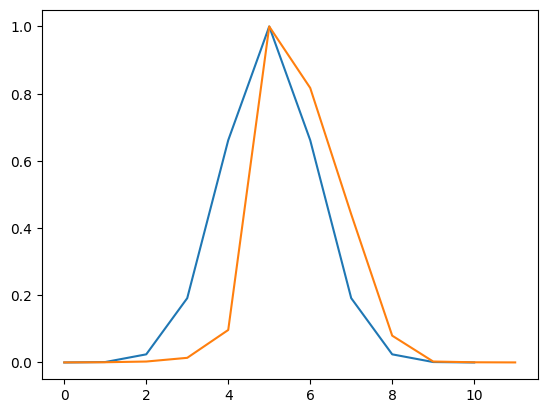

In [150]:
plt.plot(gauss_template)
plt.plot(single_template/single_template.max())

In [152]:
# --- Part 8: Computationally Intensive, Object-Based ROC Curve (Corrected) ---
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

print("--- Generating Data for Computationally Intensive ROC Curve ---")
print("Warning: This may take a significant amount of time.")

# Use a coarser set of thresholds to make the run time more manageable
roc_thresholds_intensive = np.linspace(5.0, 11.0, 25) 

# The total number of "positive" cases is the number of injected signals
n_total_positives = N_INJECTIONS
# The total number of "negative" cases is effectively the number of independent sightlines
n_total_negatives = N_PIXELS 

# Store the results for each method
all_roc_results = {}

# --- THIS IS THE FIRST FIX ---
# Create the correctly normalized SNR cube for the "Simple Threshold" method
snr_cube_simple = delay_filtered_cube / noise_spectrum
# -----------------------------

# We need the four data cubes from the previous analysis
all_cubes_to_test = [
    ("Simple Threshold", snr_cube_simple), # Use the corrected cube here
    ("Gaussian Template", snr_cube_gauss),
    ("Single OHM Template", snr_cube_single),
    ("Full OHM Template Bank", snr_cube_3d)
]

# Main loop over each of the four methods
for name, cube in all_cubes_to_test:
    tpr_list, fpr_list = [], []
    print(f"\nProcessing method: {name}")
    
    # Loop over each threshold value
    for thresh in tqdm(roc_thresholds_intensive, desc=f"Testing Thresholds for {name}"):
        
        # --- THIS IS THE SECOND FIX ---
        # 1. Find candidates using the full 3D clustering algorithm, now with freqs_mhz
        found_candidates = ocf.find_candidates_3d_dbscan(
            snr_cube=cube.reshape(GRID_SHAPE + (len(FREQS_MHZ),)),
            snr_threshold=thresh,
            eps=DBSCAN_EPS,
            min_samples=DBSCAN_MIN_SAMPLES,
            freqs_mhz=FREQS_MHZ # Pass the frequency axis
        )
        # ---------------------------
        
        # 2. Match candidates to ground truth to get TP/FP counts
        if len(found_candidates) > 0:
            # Vetting step to remove candidates outside the band or in RFI zones
            vetted_candidates = []
            for cand in found_candidates:
                centroid_freq = cand['centroid_z_freq']
                is_in_band = (FREQS_MHZ.min() <= centroid_freq <= FREQS_MHZ.max())
                if not is_in_band: continue
                freq_idx = np.argmin(np.abs(FREQS_MHZ - centroid_freq))
                is_in_clean_channel = rfi_mask_boolean[freq_idx]
                if not is_in_clean_channel: continue
                vetted_candidates.append(cand)

            matched_results = ocf.match_candidates_to_truth_3d(
                candidates=vetted_candidates,
                ground_truth=ground_truth,
                grid_shape=GRID_SHAPE,
                freqs_mhz=FREQS_MHZ
            )
            n_tp = len(matched_results['true_positives'])
            n_fp = len(matched_results['false_positives'])
        else:
            n_tp = 0
            n_fp = 0
            
        # 3. Calculate and store the rates
        tpr = n_tp / n_total_positives if n_total_positives > 0 else 0
        fpr = n_fp / n_total_negatives if n_total_negatives > 0 else 0
        tpr_list.append(tpr)
        fpr_list.append(fpr)
        
    all_roc_results[name] = {'tpr': np.array(tpr_list), 'fpr': np.array(fpr_list)}

--- Generating Data for Computationally Intensive ROC Curve ---

Processing method: Simple Threshold


Testing Thresholds for Simple Threshold:   0%|          | 0/25 [00:00<?, ?it/s]


Processing method: Gaussian Template


Testing Thresholds for Gaussian Template:   0%|          | 0/25 [00:00<?, ?it/s]


Processing method: Single OHM Template


Testing Thresholds for Single OHM Template:   0%|          | 0/25 [00:00<?, ?it/s]


Processing method: Full OHM Template Bank


Testing Thresholds for Full OHM Template Bank:   0%|          | 0/25 [00:00<?, ?it/s]

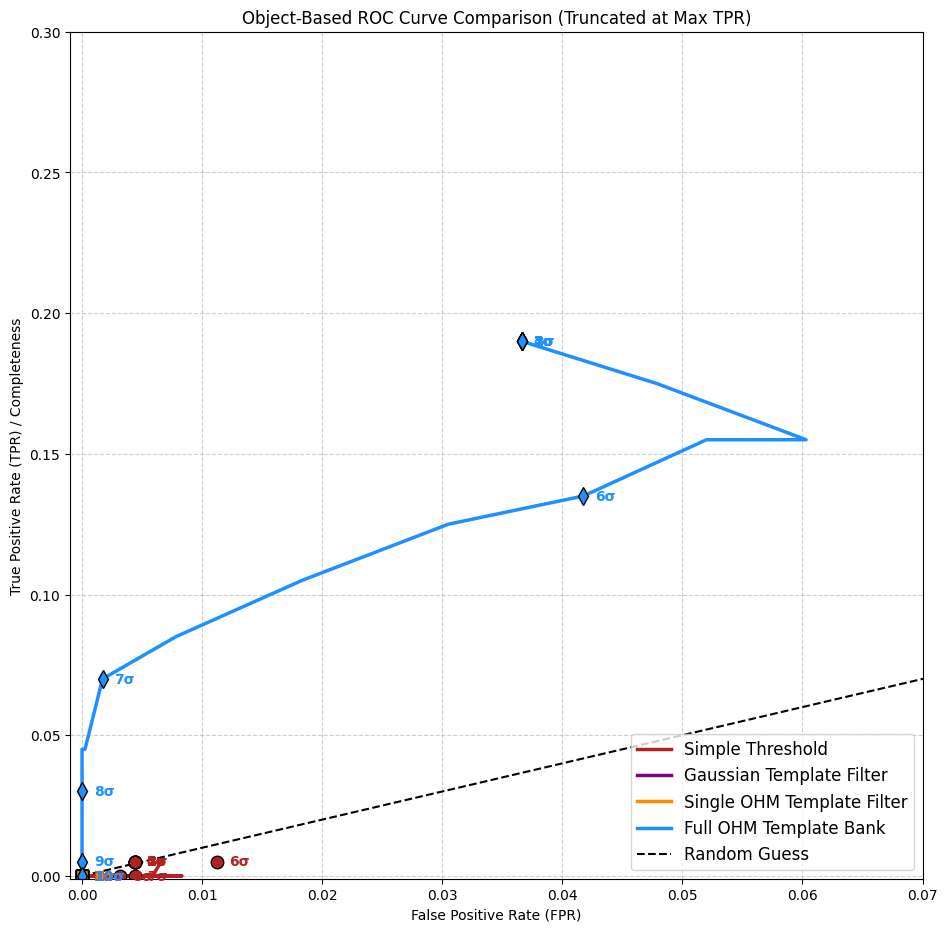

In [159]:
# --- Final ROC Plotting ---
plt.figure(figsize=(11, 11))
ax = plt.gca()

# --- Define the visible area of the plot FIRST ---
xlim = (-0.001, 0.07)
ylim = (-0.001, 0.3)
ax.set_xlim(xlim)
ax.set_ylim(ylim)

# --- Data for plotting ---
all_curves_data = [
    (all_roc_results['Simple Threshold'], 'Simple Threshold', 'firebrick', 'o'),
    (all_roc_results['Gaussian Template'], 'Gaussian Template Filter', 'purple', 'v'),
    (all_roc_results['Single OHM Template'], 'Single OHM Template Filter', 'darkorange', 's'),
    (all_roc_results['Full OHM Template Bank'], 'Full OHM Template Bank', 'dodgerblue', 'd')
]

# --- Main Plotting Loop with Robust Truncation Logic ---
for results, label, color, marker in all_curves_data:
    # Reverse the arrays so they run from (0,0) towards (1,1)
    fpr_vals = results['fpr'][::-1]
    tpr_vals = results['tpr'][::-1]

    # Find the maximum TPR value achieved by this curve
    max_tpr = np.max(tpr_vals)
    
    # Find the index of the FIRST time this maximum TPR is reached
    knee_idx_list = np.where(tpr_vals >= max_tpr * 0.999)[0]
    
    if len(knee_idx_list) > 0:
        knee_idx = knee_idx_list[0]
        # Plot the data only up to and including this "knee"
        ax.plot(fpr_vals[:knee_idx+1], tpr_vals[:knee_idx+1], label=label, color=color, lw=2.5)
    else:
        # If for some reason no point reaches the max, plot the whole thing
        ax.plot(fpr_vals, tpr_vals, label=label, color=color, lw=2.5)


# Plot the random guess line
ax.plot([0, 1], [0, 1], 'k--', label='Random Guess')

# --- Add annotated sigma markers with boundary checks ---
sigma_markers = range(1, 11) # From 3 to 10 sigma
reversed_thresholds = roc_thresholds_intensive[::-1]

for sigma in sigma_markers:
    # Find the index in our REVERSED threshold array closest to the target sigma
    idx = (np.abs(reversed_thresholds - sigma)).argmin()
    
    for results, label, color, marker in all_curves_data:
        # Get the data points from the REVERSED arrays
        fpr_at_sigma = results['fpr'][::-1][idx]
        tpr_at_sigma = results['tpr'][::-1][idx]
        
        # --- THIS IS THE FIX ---
        # Only plot the marker and text if it falls within our predefined x and y limits.
        if xlim[0] <= fpr_at_sigma <= xlim[1] and ylim[0] <= tpr_at_sigma <= ylim[1]:
            ax.plot(fpr_at_sigma, tpr_at_sigma, marker, color=color, markersize=9, markeredgecolor='black')
            ax.text(fpr_at_sigma + 0.001, tpr_at_sigma, f'{sigma}σ', 
                    color=color, fontsize=10, ha='left', va='center', weight='bold')

# --- Final plot settings ---
ax.set_xlabel('False Positive Rate (FPR)')
ax.set_ylabel('True Positive Rate (TPR) / Completeness')
ax.set_title('Object-Based ROC Curve Comparison (Truncated at Max TPR)')
ax.legend(loc='lower right', fontsize=12)
ax.grid(True, which="both", ls="--", alpha=0.6)
fig.savefig('ROC_scenario_3.jpeg', dpi=300)

plt.show()

---
### A Figure of Merit: The ROC Curve from Radar to Radio Astronomy

To truly understand how well our search pipeline performs, we need a "figure of merit"—a single, quantitative measure of its effectiveness. While metrics like **completeness** and **purity** are informative for a *single* threshold, they don't capture the full picture of the trade-offs involved in a detection algorithm. The **Receiver Operating Characteristic (ROC)** curve provides this complete picture.

#### From Radar Engineering to the Cosmos 📡

The ROC curve was originally developed during World War II for operators of **radar** signal receivers. The fundamental problem they faced is identical to ours in radio astronomy: how do you set your detection threshold to reliably distinguish a faint, real signal (an enemy aircraft) from the ever-present background noise (atmospheric static, instrument noise)?

* Set the threshold **too low**, and you get a high **completeness** (you find every real aircraft), but you are flooded with **false positives** (you mistake noise for an aircraft), making the system useless.
* Set the threshold **too high**, and your **purity** is perfect (every detection is real), but your **completeness** is terrible (you miss most of the real aircraft).

The ROC curve was born from this trade-off. By plotting the **True Positive Rate** (TPR, or completeness) against the **False Positive Rate** (FPR) for every possible threshold setting, radar engineers could visualize the full performance space of their system.

#### Connecting to Radio Astronomy

This concept translates perfectly to our OHM search. An "aircraft" is a real OH megamaser, and the "noise" is the thermal noise of the telescope and the radio sky. The mathematical framework is identical.

* **False Positive Rate (FPR)**: In radar, this is the probability of a false alarm. In our search, it's the rate at which random noise fluctuations cross our SNR threshold.
* **True Positive Rate (TPR)**: In radar, this is the probability of detection. For us, it's our search **completeness**.

The goal is to have a curve that pushes as far as possible into the top-left corner, which signifies a high TPR for a very low FPR. By comparing the ROC curves of different search algorithms—like our simple threshold vs. our template bank—we can definitively prove which method is superior. It's not just about how many signals we find at a single 7σ threshold; it's about which method gives us the highest completeness for the *lowest possible cost* in false alarms across all possible thresholds. This robust, historical technique gives us the ultimate figure of merit for our search pipeline.

In [39]:
import numpy as np

def find_sigma_for_fpr(target_fpr, fpr_data, threshold_data):
    """
    Finds the sigma threshold that corresponds to a desired False Positive Rate (FPR).

    This function searches the results from an ROC curve analysis to find the lowest
    sigma value that produces a False Positive Rate less than or equal to the target.

    Args:
        target_fpr (float): The desired maximum False Positive Rate (e.g., 1e-4).
        fpr_data (np.ndarray): The array of FPR values from the ROC analysis, sorted
                               by increasing sigma threshold.
        threshold_data (np.ndarray): The array of corresponding sigma thresholds.

    Returns:
        float: The sigma threshold corresponding to the target FPR. Returns None if
               the target FPR is too low and was not achieved in the tested range.
    """
    # The roc_thresholds_intensive array goes from low to high sigma,
    # which means the fpr_data array goes from high to low FPR.
    # We want to find the first index where the FPR is <= our target.
    valid_indices = np.where(fpr_data <= target_fpr)[0]
    
    if len(valid_indices) > 0:
        # The first index in this list corresponds to the lowest sigma
        # that achieves the desired FPR or better.
        first_valid_index = valid_indices[0]
        sigma_cutoff = threshold_data[first_valid_index]
        actual_fpr = fpr_data[first_valid_index]
        
        print(f"To achieve an FPR of <= {target_fpr:.1e}:")
        print(f"-> Set the detection threshold to: {sigma_cutoff:.2f} sigma")
        print(f"   (This yields an actual FPR of {actual_fpr:.1e})")
        return sigma_cutoff
    else:
        print(f"Target FPR of {target_fpr:.1e} was not achieved.")
        print("You may need to test higher sigma thresholds.")
        return None

# --- Example Usage ---
# We will use the results from the object-based ROC curve analysis for the best method.
fpr_values = all_roc_results['Full OHM Template Bank']['fpr']
sigma_thresholds = roc_thresholds_intensive

# Define our desired false positive rate (e.g., 1 in 10,000 pixels)
target_fpr_value = 3.7e-3

# Find the corresponding sigma cutoff
sigma_needed = find_sigma_for_fpr(target_fpr_value, fpr_values, sigma_thresholds)

To achieve an FPR of <= 3.7e-03:
-> Set the detection threshold to: 7.21 sigma
   (This yields an actual FPR of 3.7e-03)
